# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


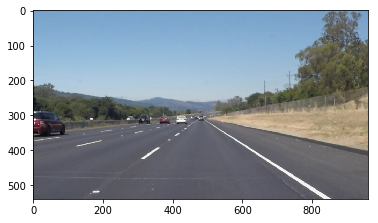

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

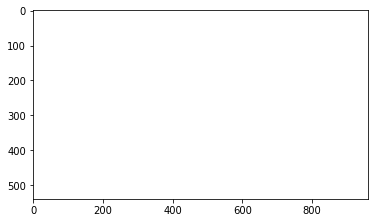

In [5]:
from IPython.display import display
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import os
import math

# interactive filter builder (features ordered by importance):
# exposes min/max range on each channel and displays them
# applys filters to image in real time
# choose initial color space transform (just choose HSV to simplify)

name = 'solidYellowCurve.jpg'
image = mpimg.imread('test_images/' + name)
input_image = image
input_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def filter_hsv(hmin, hmax, smin, smax, vmin, vmax):
    input_copy = np.copy(input_image)
    thresholds = ((input_image[:,:,0] >= hmin) & (input_image[:,:,0] <= hmax) &
                  (input_image[:,:,1] >= smin) & (input_image[:,:,1] <= smax) &
                  (input_image[:,:,2] >= vmin) & (input_image[:,:,2] <= vmax))
    input_copy[thresholds] = [255,255,255]
    # clunky...
    inverse = ((input_image[:,:,0] < hmin) | (input_image[:,:,0] > hmax) |
               (input_image[:,:,1] < smin) | (input_image[:,:,1] > smax) |
               (input_image[:,:,2] < vmin) | (input_image[:,:,2] > vmax))
    input_copy[inverse] = [0,0,0]
    
    plt.imshow(input_copy)

# interact(f, x=10)
# color = widgets.ColorPicker(value='#000000')

interactive(filter_hsv,
            hmin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            hmax=widgets.IntSlider(min=0,max=255,step=1,value=255),
            smin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            smax=widgets.IntSlider(min=0,max=255,step=1,value=255),
            vmin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            vmax=widgets.IntSlider(min=0,max=255,step=1,value=255))

# good yellow hsv
# hmin=13
# hmax=23
# smin=73
# smax=160
# vmin=145
# vmax=252

# good yellow hsv 2
# hmin=15
# hmax=38
# smin=28
# smax=175
# vmin=186
# vmax=255

# good yellow rbg (better than hsv)
# rmin=198
# rmax=255
# gmin=113
# gmax=255
# bmin=82
# bmax=156




In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

input_images = [(name, mpimg.imread('test_images/' + name)) for name in os.listdir("test_images/")]

def show_images(input_images, title='', ncols=1):
    #plt.title(title)
    nrows = math.ceil(len(input_images)/ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(40,40))
    flattened = []
    for axr in axs:
        flattened.extend(axr)
    for ax, (name, image) in zip(flattened, input_images):
        ax.imshow(image)
        ax.set_title(name)
    plt.show()

'''Note: before and after are lists of (name, img) tuples'''
def show_transform(before, after, before_cmap=None, after_cmap=None, title=''):
    #plt.title(title)
    fig, axs = plt.subplots(nrows=len(before), ncols=2, squeeze=False, sharex='all', sharey='all', figsize=(12,25))
    fig.tight_layout()
    for ax, ((bname, bimg), (aname, aimg)) in zip(axs, zip(before, after)):
        if before_cmap:
            ax[0].imshow(bimg, cmap=before_cmap)
        else:
            ax[0].imshow(bimg)
        ax[0].set_title(bname)
        if after_cmap:
            ax[1].imshow(aimg, cmap=after_cmap)
        else:
            ax[1].imshow(aimg)
        ax[1].set_title(aname)
    plt.show()

'''Note: before and after are lists of (name, img) tuples'''
def show_hsv_channels(images):
    #plt.title(title)
    fig, axs = plt.subplots(nrows=len(images), ncols=4, squeeze=False, sharex='all', sharey='all', figsize=(12,25))
    fig.tight_layout()
    
    chanimages = []
    for ax, (name, image) in zip(axs, images):
        color_select = np.copy(image)
        cv2.cvtColor(color_select, cv2.COLOR_RGB2HSV)
        #hue = cv2.extractChannel(color_select, 0)
        chans = cv2.split(color_select)
        ax[0].imshow(image)
        for i, chan in zip(range(len(chans)), chans):
            ax[i+1].imshow(chan, cmap='gray')
    
    plt.show()

# The tools you have are color selection, region of interest selection,
# grayscaling, Gaussian smoothing, Canny Edge Detection and Hough
# Tranform line detection.


############ color selection (select white and yellow) #############
def get_white_selected(image):
    color_select = np.copy(image)

    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    WHITE_THRESHOLD = 200
    red_threshold = WHITE_THRESHOLD
    green_threshold = WHITE_THRESHOLD
    blue_threshold = WHITE_THRESHOLD
    ######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select
    
# Grab the x and y size and make a copy of the image
white_selected = []
for (name, image) in input_images:
    color_select = get_white_selected(image)
    white_selected.append((name, color_select))
###################################################################
### find yellow lanes ###
#show_hsv_channels(input_images)

# TODO(j): refactor to generic channel names
def filter_3chan(input_image, hmin, hmax, smin, smax, vmin, vmax):
    input_copy = np.copy(input_image)
    thresholds = ((input_image[:,:,0] >= hmin) & (input_image[:,:,0] <= hmax) &
                  (input_image[:,:,1] >= smin) & (input_image[:,:,1] <= smax) &
                  (input_image[:,:,2] >= vmin) & (input_image[:,:,2] <= vmax))
    input_copy[thresholds] = [255,255,255]
    # clunky...
    inverse = ((input_image[:,:,0] < hmin) | (input_image[:,:,0] > hmax) |
               (input_image[:,:,1] < smin) | (input_image[:,:,1] > smax) |
               (input_image[:,:,2] < vmin) | (input_image[:,:,2] > vmax))
    input_copy[inverse] = [0,0,0]
    return input_copy

def get_yellow_selected(image):
    return filter_3chan(input_image=image, hmin=198,hmax=255,smin=113,smax=255,vmin=82,vmax=156)

yellow_selected = []
for (name, image) in input_images:
    yellow = get_yellow_selected(image)
    yellow_selected.append((name, yellow))
    
def get_merged(white_image, yellow_image):
    return np.maximum(white_image, yellow_image)

# merge white and yellow lane markers
color_selected = []
for ((white_name, white_image), (yellow_lane, yellow_image)) in zip(white_selected, yellow_selected):
    # white means selected, so just take pixels with the highest value from each image, color-wise
    color_selected.append(('merged: '+white_name, get_merged(white_image, yellow_image)))
    
##############################################################
# apply area of interest to lanes

# TODO(j): a bit hacky
ysize = color_selected[0][1].shape[0]
xsize = color_selected[0][1].shape[1]

left_bottom = [0, 539]
right_bottom = [1000, 539]
apex = [500, 300]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

def get_area_of_interest(image):
    region_select = np.copy(image)                
    # TODO(j): make the filters more elegant, like this is
    # color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
    region_select[~region_thresholds] = [0, 0, 0]
    return region_select

lane_region_selected = []
for name, image in color_selected:
    lane_region_selected.append(('region: '+name, get_area_of_interest(image)))
    
################################################
# canny edge detection  
    
def get_canny(image):
    canny_copy = np.copy(image)
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 40
    high_threshold = 100
    return cv2.Canny(blur_gray, low_threshold, high_threshold)

canny_images = []
for name, image in lane_region_selected:
    edges = get_canny(image)
    canny_images.append(('canny: '+name, edges))
    
#################################################
# hough transform for lane lines

import random

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 1000    # maximum gap in pixels between connectable line segments
RAND_LINE_COLOR = True
line_color = (255,0,0)

# TODO(j): a bit hacky
ysize = color_selected[0][1].shape[0]
xsize = color_selected[0][1].shape[1]

def get_lanes(input_image, canny_image):
    hough_copy = np.copy(canny_image)
    final_copy = np.copy(input_image)
    line_image = np.copy(input_image)*0 # creating a blank to draw lines on
    two_lane_line_image = np.copy(input_image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(hough_copy, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            if RAND_LINE_COLOR:
                line_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.line(line_image,(x1,y1),(x2,y2),line_color,10)
            
    # Split lines into buckets based on positive or negative slope and compute average slope and y intercept
    left_lane_total_m = 0
    left_lane_total_b = 0
    left_lane_count = 0
    right_lane_total_m = 0
    right_lane_total_b = 0
    right_lane_count = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            # y1-y2=m(x1-x2)
            # y = mx+b
            # m = (y1-y2)/(x1-x2)
            # b = y-mx
            # TODO(j): convert to polar
            if x1-x2 == 0:
                continue
            m = (y1-y2)/(x1-x2)
            b = y1-m*x1
            if m > 0:
                left_lane_total_m += m
                left_lane_total_b += b
                left_lane_count += 1
            else:
                right_lane_total_m += m
                right_lane_total_b += b
                right_lane_count += 1
    right_lane_m = right_lane_total_m / right_lane_count
    right_lane_b = right_lane_total_b / right_lane_count
    left_lane_m = left_lane_total_m / left_lane_count
    left_lane_b = left_lane_total_b / left_lane_count
    print (right_lane_m, right_lane_b, left_lane_m, left_lane_b)
    
    # Plot average lanes ~half way up the image (x = (y-b)/m)
    y = ysize
    left_bottom = int((y-left_lane_b)/left_lane_m),y
    right_bottom = int((y-right_lane_b)/right_lane_m),y
    y = ysize*.65
    left_top = int((y-left_lane_b)/left_lane_m),int(y)
    right_top = int((y-right_lane_b)/right_lane_m),int(y)
    cv2.line(two_lane_line_image,left_bottom,left_top,(255,0,0),10)
    cv2.line(two_lane_line_image,right_bottom,right_top,(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((hough_copy, hough_copy, hough_copy))
    two_lane_color_edges = np.dstack((hough_copy, hough_copy, hough_copy)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    two_lanes_with_lines = cv2.addWeighted(two_lane_color_edges, 0.8, two_lane_line_image, 1, 0)
    # Draw lanes on original
    final = cv2.addWeighted(final_copy, 0.8, two_lane_line_image, 1, 0)
    return lines_edges, two_lanes_with_lines, final
    

hough_images = []
two_lane_images = []
final_images = []
for ((canny_name, canny_image),(input_name, input_image)) in zip(canny_images, input_images):
    lines_edges, two_lanes_with_lines, final = get_lanes(input_image, canny_image)
    hough_images.append(('hough: '+name, lines_edges))
    two_lane_images.append(('two_lane: '+name, two_lanes_with_lines))
    final_images.append(('with_lanes: '+name, final))

#TODO(j): write image files into test_images_output for each pipeline stage


-0.712722338096 648.397773843 0.635251633983 1.66832685062
-0.701822770443 643.002126573 0.624251950796 8.43256938018
-0.712336698792 654.578479913 0.583999106909 35.7807542848
-0.669252126314 662.600931505 0.588193725232 25.730593198
-0.743073297334 665.047178431 0.584274951394 32.2928567979
-0.795968090352 690.118455142 0.564860943493 36.8200545282


In [7]:
show_transform(input_images, white_selected, title='White Selected')

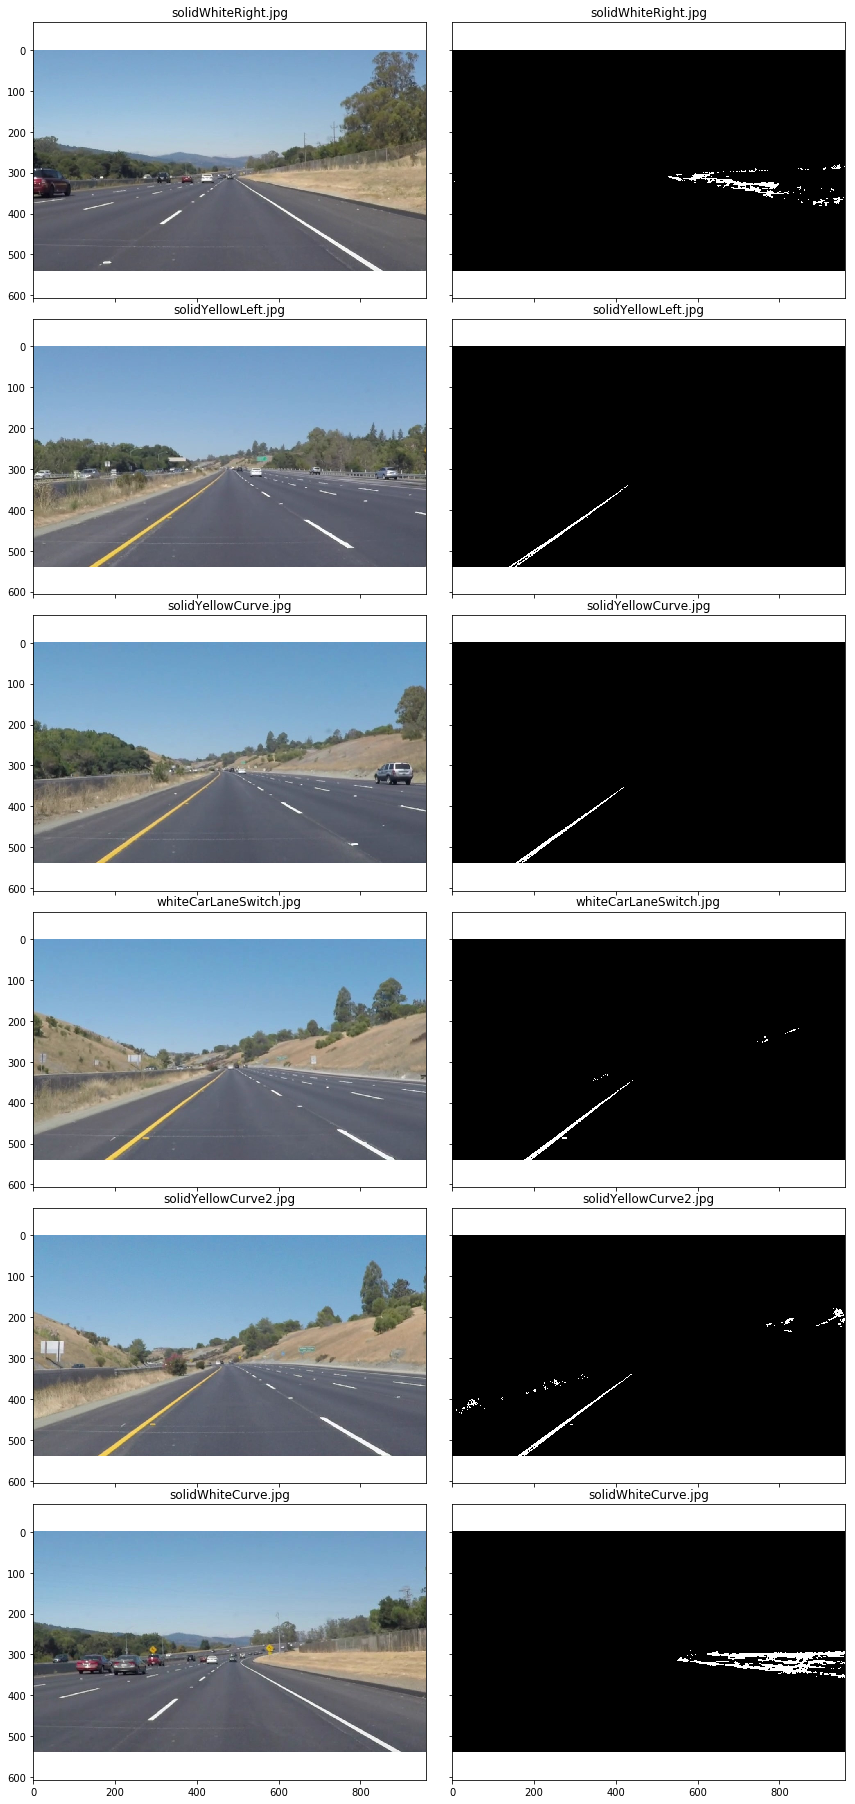

In [10]:
show_transform(input_images, yellow_selected, title='Yellow Selected')

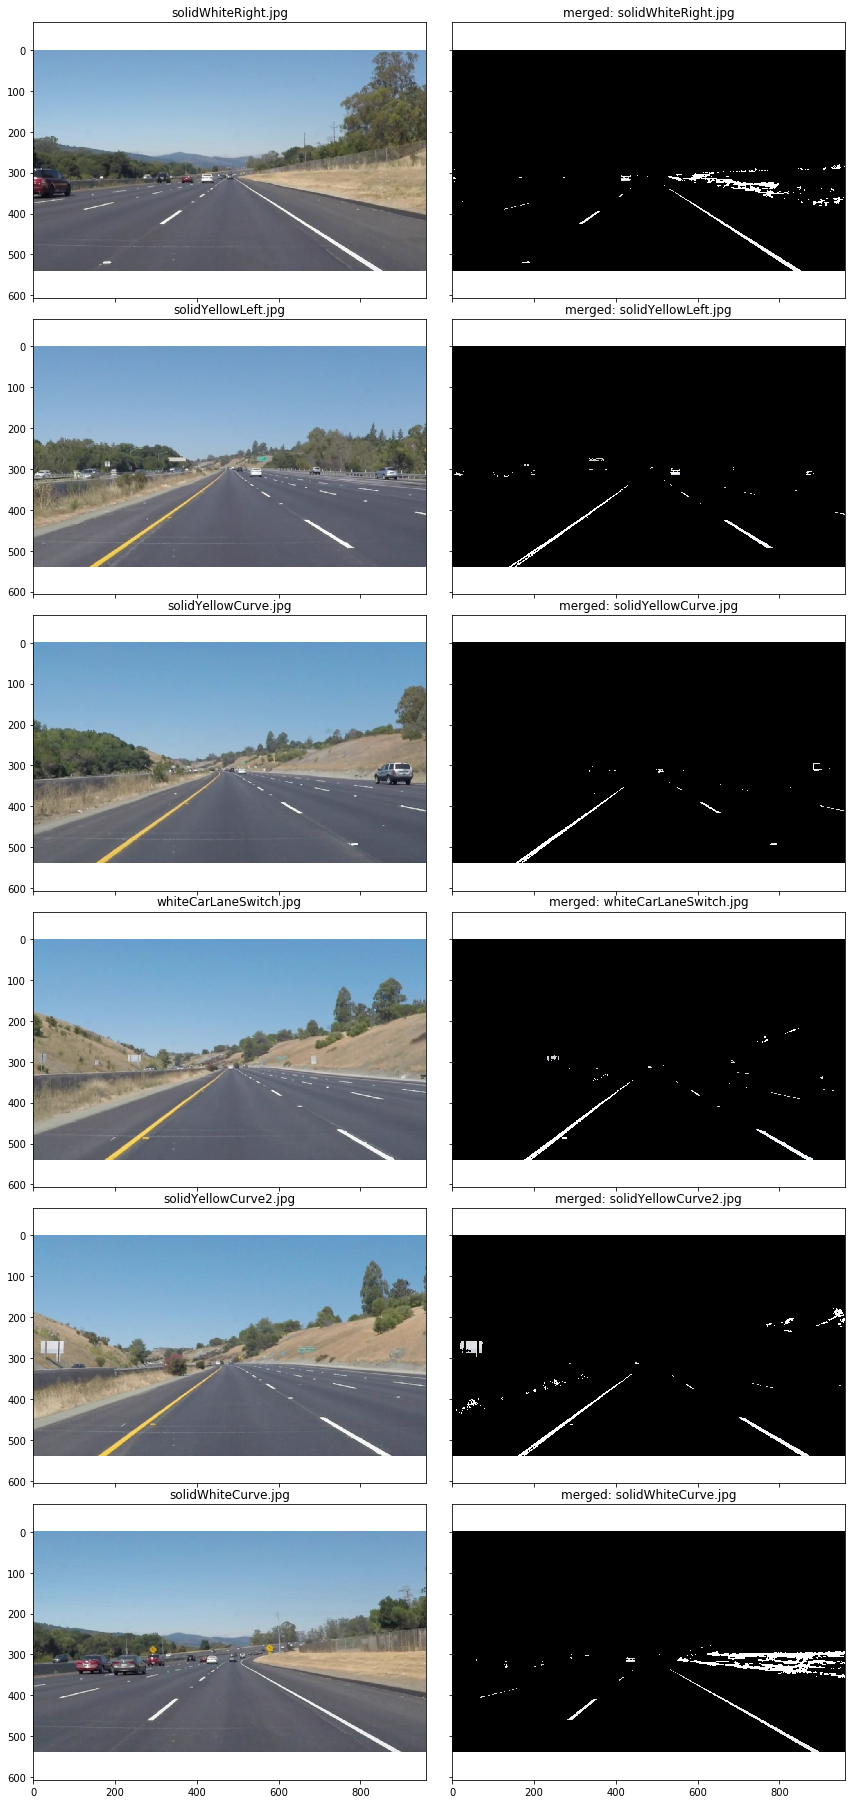

In [11]:
show_transform(input_images, color_selected, title='Color Selected')

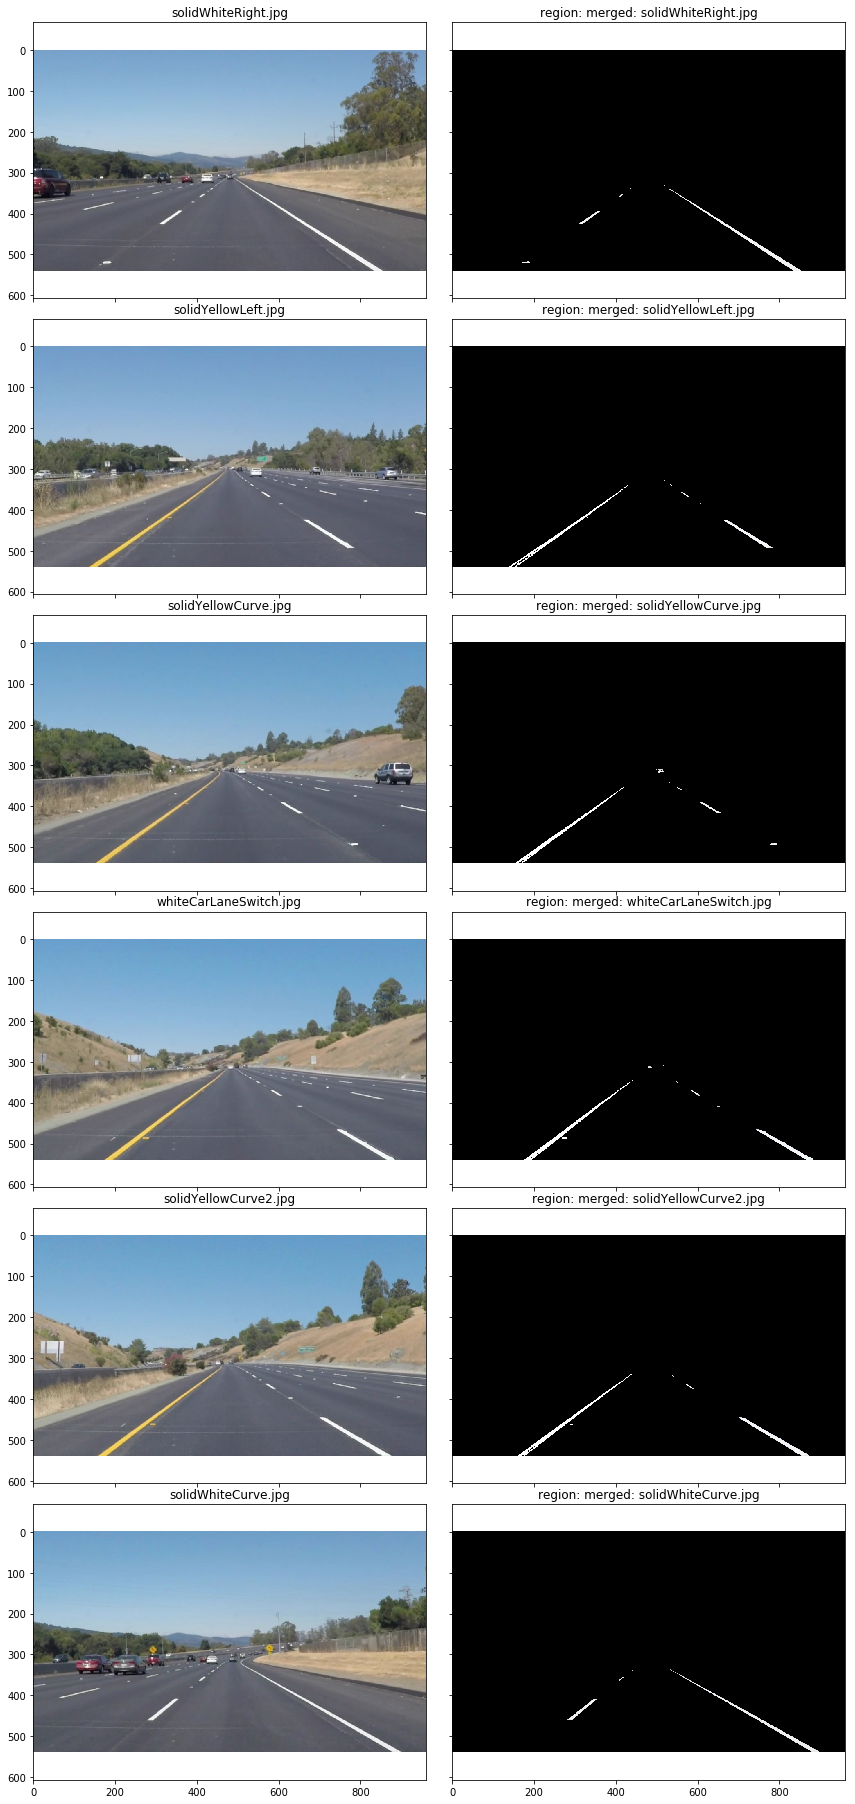

In [12]:
show_transform(input_images, lane_region_selected, title='Lane Region Selected')


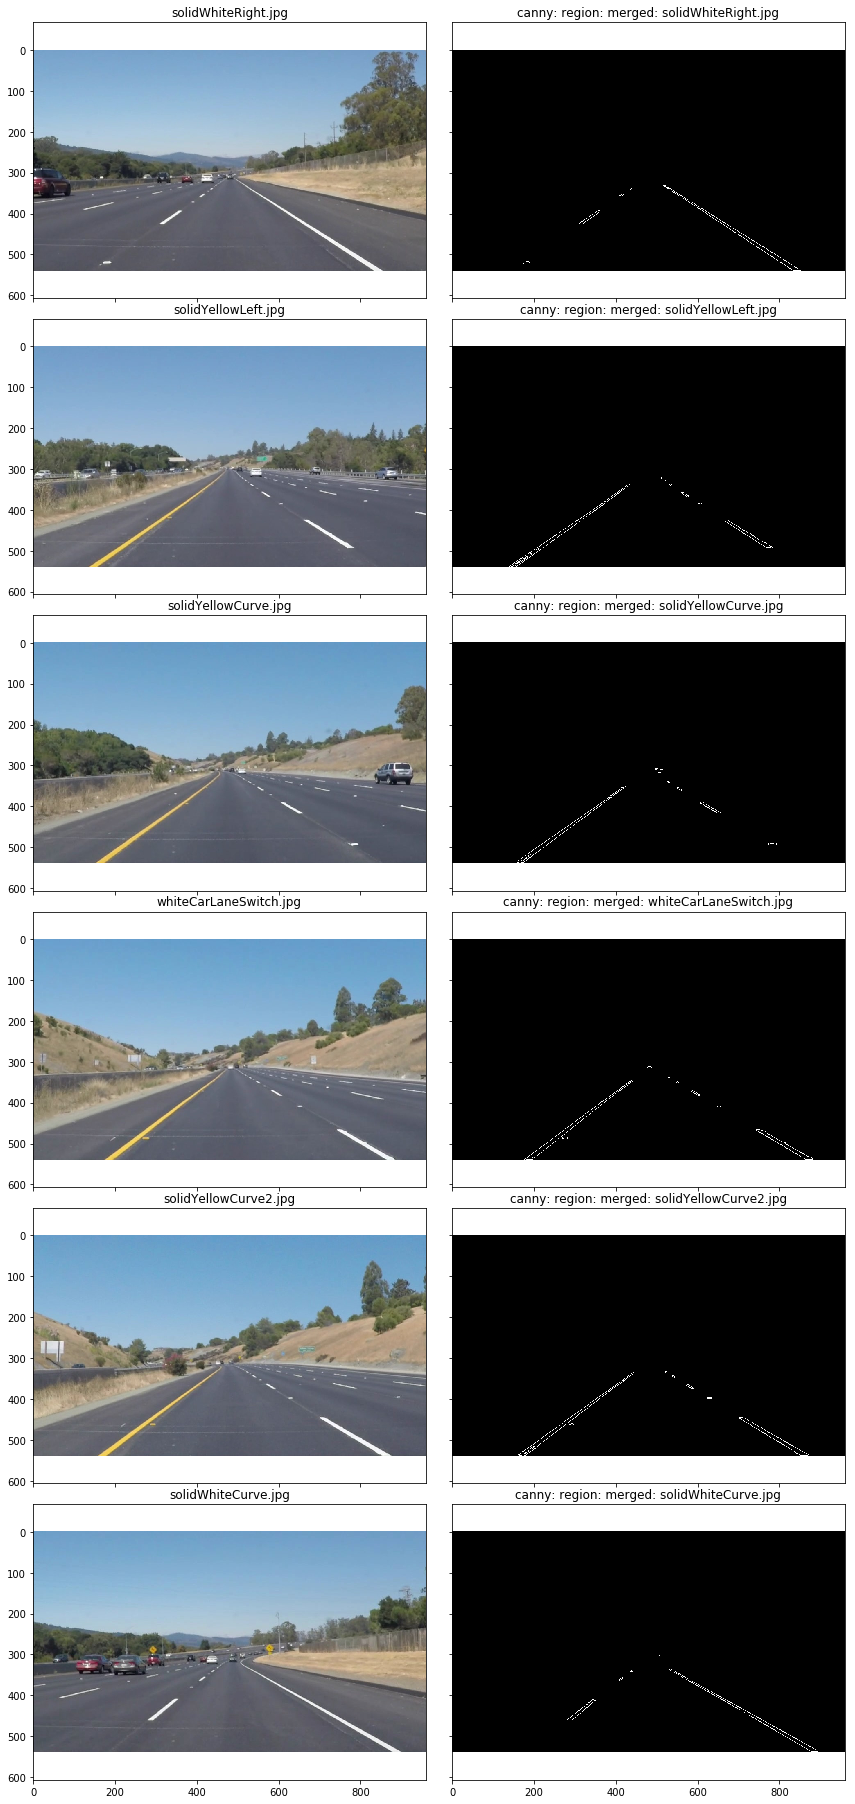

In [13]:
show_transform(input_images, canny_images, after_cmap='Greys_r', title='Canny')

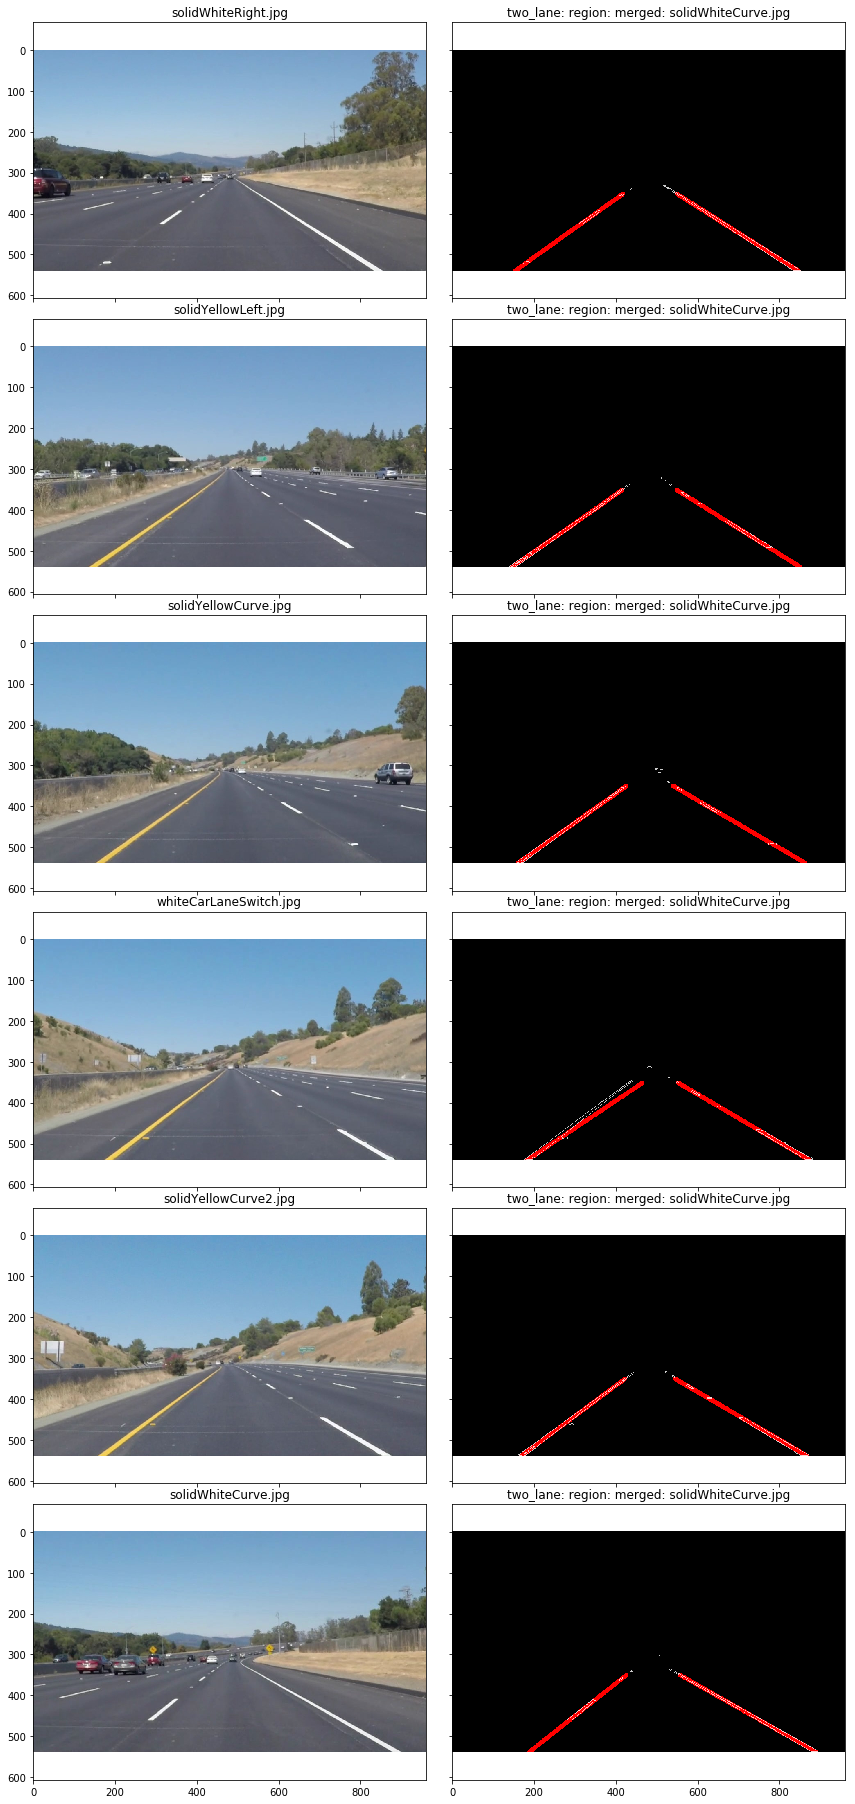

In [14]:
#show_transform(input_images, hough_images, title='Hough')
show_transform(input_images, two_lane_images, title='Two Lanes')

In [15]:
show_transform(input_images, final_images, title='Final')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
def process_image(image):
    white_selected = get_white_selected(image)
    yellow_selected = get_yellow_selected(image)
    merged = get_merged(white_selected, yellow_selected)
    lane_region_selected = get_area_of_interest(merged)
    canny_image = get_canny(lane_region_selected)
    _, _, result = get_lanes(image, canny_image)
    
    return result

-0.712722338096 648.397773843 0.635251633983 1.66832685062
-0.701822770443 643.002126573 0.624251950796 8.43256938018
-0.712336698792 654.578479913 0.583999106909 35.7807542848
-0.669252126314 662.600931505 0.588193725232 25.730593198
-0.743073297334 665.047178431 0.584274951394 32.2928567979
-0.795968090352 690.118455142 0.564860943493 36.8200545282


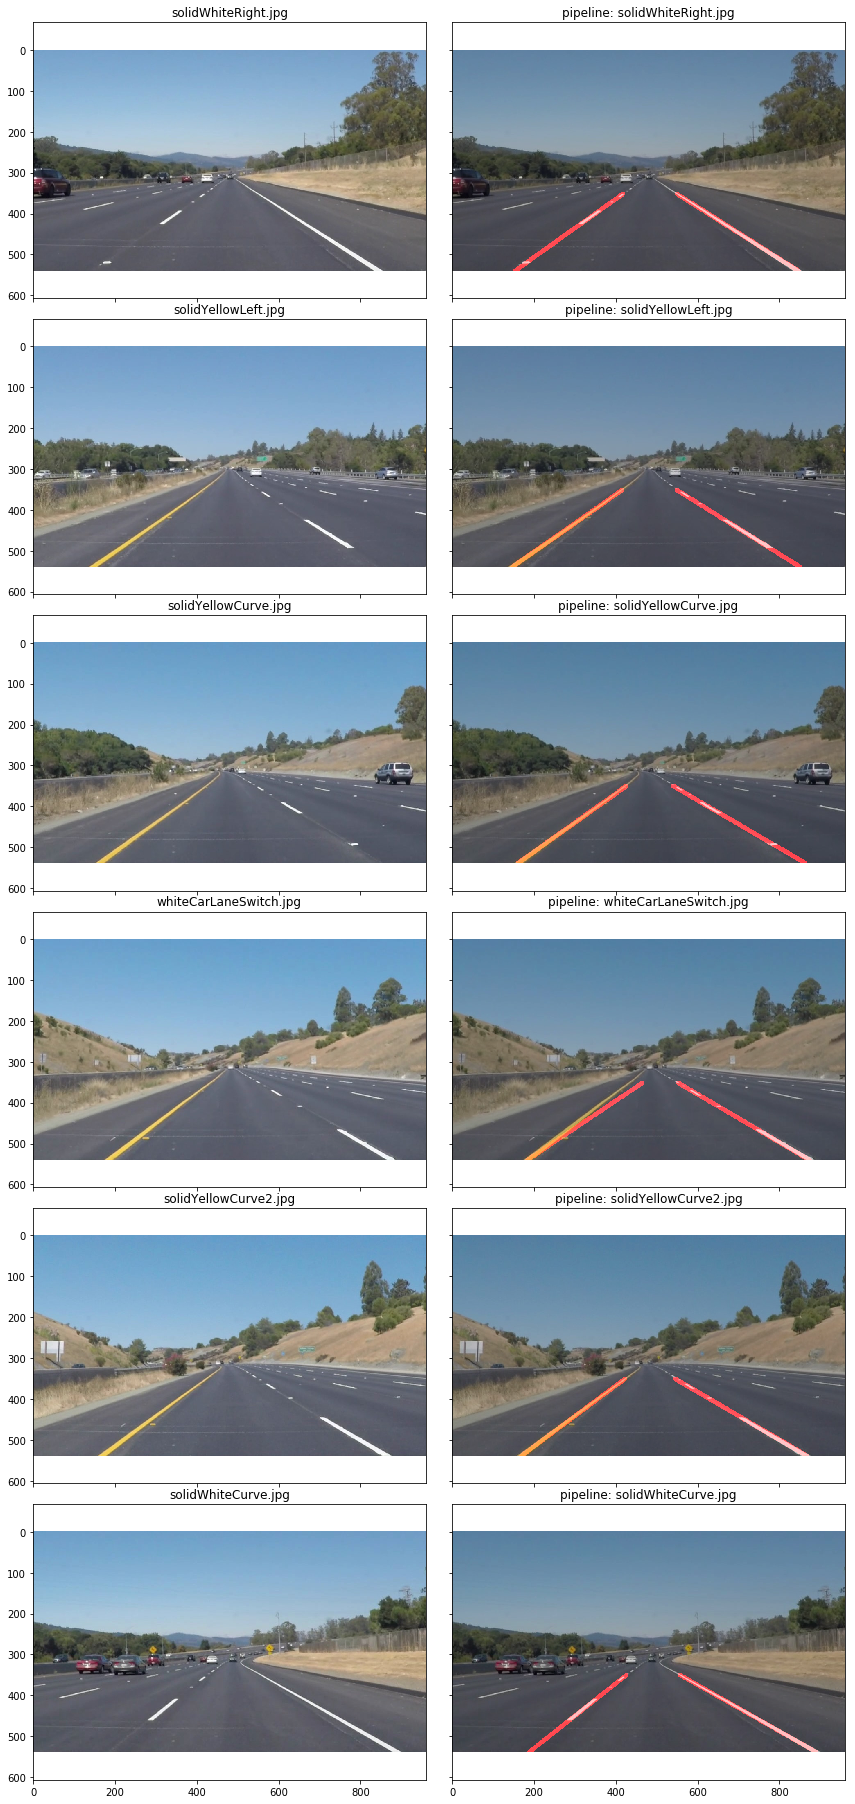

In [17]:
pipeline_images = []
for name, image in input_images:
    pipeline_images.append(('pipeline: '+name, process_image(image)))
show_transform(input_images, pipeline_images, title='Final Through Pipeline')

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

-0.762311416069 663.191222375 0.612576662408 12.417359922
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 1/222 [00:00<00:36,  6.11it/s]

-0.762311416069 663.191222375 0.612576662408 12.417359922


  1%|          | 2/222 [00:00<00:36,  5.98it/s]

-0.739031629612 655.843512728 0.635593816658 -3.39097414177


  1%|▏         | 3/222 [00:00<00:37,  5.90it/s]

-0.753937993313 662.651484866 0.612264387547 13.4648930754


  2%|▏         | 4/222 [00:00<00:37,  5.86it/s]

-0.754300330646 662.73822065 0.611652061481 13.1116882322
-0.576270159408 627.88044848 0.610108766612 13.9226728841


  3%|▎         | 6/222 [00:01<00:37,  5.74it/s]

-0.711619322546 647.017263825 0.614774546446 10.6308138751


  3%|▎         | 7/222 [00:01<00:36,  5.83it/s]

-0.715771258017 647.521924811 0.611806283924 11.7286929115


  4%|▎         | 8/222 [00:01<00:36,  5.87it/s]

-0.732642773364 653.622770546 0.614794258722 9.95840835299


  4%|▍         | 9/222 [00:01<00:36,  5.79it/s]

-0.713094771553 645.711121948 0.611210242495 12.6396918802
-0.708779258902 646.981815323 0.613040777303 13.4943940295


  5%|▍         | 11/222 [00:01<00:37,  5.58it/s]

-0.714447629751 650.659901853 0.609236681584 19.2152452355


  5%|▌         | 12/222 [00:02<00:36,  5.69it/s]

-0.711880563332 650.60874494 0.614674222642 17.7026778765


  6%|▌         | 13/222 [00:02<00:36,  5.75it/s]

-0.716377289761 651.388585137 0.632826594636 3.5709834663


  6%|▋         | 14/222 [00:02<00:35,  5.78it/s]

-0.722079090737 649.685569225 0.637990238703 1.08473517484


  7%|▋         | 15/222 [00:02<00:35,  5.77it/s]

-0.647620593992 637.723846391 0.633443173033 2.13445869734


  7%|▋         | 16/222 [00:02<00:35,  5.84it/s]

-0.611356875016 628.576687789 0.635562732383 -0.702468966926


  8%|▊         | 17/222 [00:02<00:34,  5.88it/s]

-0.555168444345 616.57908448 0.639028562745 -4.02093890649
-0.693184535688 636.520546066 0.641968197091 -4.04504853711


  9%|▊         | 19/222 [00:03<00:35,  5.78it/s]

-0.690614296232 638.324136496 0.638026022624 -1.45582993209


  9%|▉         | 20/222 [00:03<00:34,  5.89it/s]

-0.686130142969 637.411099249 0.636853952518 0.0645773004758


  9%|▉         | 21/222 [00:03<00:34,  5.90it/s]

-0.713357504979 648.850777295 0.638296978397 0.243751271146


 10%|▉         | 22/222 [00:03<00:34,  5.72it/s]

-0.695779859812 643.005169376 0.639428549846 -0.0350102157435
-0.71179532433 648.164881318 0.632935528866 3.82774487027


 11%|█         | 24/222 [00:04<00:34,  5.67it/s]

-0.695812490223 643.167043199 0.641710338648 -1.58591690833


 11%|█▏        | 25/222 [00:04<00:34,  5.78it/s]

-0.70959705342 645.657741574 0.640418676774 -1.83672161448
-0.705898936985 643.467102287 0.637352864829 -0.0406102036065


 12%|█▏        | 27/222 [00:04<00:34,  5.65it/s]

-0.697201149234 644.442506426 0.639189638945 -1.06567408321


 13%|█▎        | 28/222 [00:04<00:33,  5.76it/s]

-0.59310214057 629.799837564 0.634565253123 0.883634944116


 13%|█▎        | 29/222 [00:05<00:34,  5.64it/s]

-0.525100204525 617.768633609 0.635327329875 1.47954354336


 14%|█▎        | 30/222 [00:05<00:33,  5.74it/s]

-0.720338451533 651.638841155 0.636168298913 0.0537733326182


 14%|█▍        | 31/222 [00:05<00:33,  5.77it/s]

-0.741266479615 656.6537204 0.63213101678 3.10134666427


 14%|█▍        | 32/222 [00:05<00:32,  5.83it/s]

-0.726525424278 652.10949709 0.638117283297 -1.787749349
-0.734791921365 654.691883222 0.635199835219 -0.752476266883


 15%|█▍        | 33/222 [00:05<00:33,  5.67it/s]

-0.721889913338 650.606130423 0.635874073756 -0.784210773152


 16%|█▌        | 35/222 [00:06<00:33,  5.50it/s]

-0.70856986461 646.033817031 0.633554442732 1.60149645331


 16%|█▌        | 36/222 [00:06<00:32,  5.67it/s]

-0.738930355282 658.455822979 0.636017279273 1.67105387292


 17%|█▋        | 37/222 [00:06<00:32,  5.66it/s]

-0.712424740011 649.424329502 0.63521614248 1.67469851153


 17%|█▋        | 38/222 [00:06<00:31,  5.80it/s]

-0.718255651002 652.009148637 0.63940505031 -1.63534507706


 18%|█▊        | 39/222 [00:06<00:30,  5.95it/s]

-0.710073875701 648.930417288 0.639079916453 -0.697092380656


 18%|█▊        | 40/222 [00:06<00:30,  5.98it/s]

-0.593175302309 629.617216041 0.628206129651 3.67856848922


 18%|█▊        | 41/222 [00:07<00:30,  5.86it/s]

-0.575608097708 626.958615212 0.634104979748 1.60610774297


 19%|█▉        | 42/222 [00:07<00:30,  5.88it/s]

-0.750834216936 660.749827234 0.662188481617 -19.0837481606


 20%|█▉        | 44/222 [00:07<00:32,  5.47it/s]

-0.743880332397 657.916541657 0.663576776972 -19.0942593752
-0.756631837435 662.164437023 0.65728234862 -14.7365531279


 21%|██        | 46/222 [00:08<00:31,  5.62it/s]

-0.721581205995 647.713646548 0.655650082115 -13.9274530099
-0.738670804618 653.757420272 0.658156124678 -16.1429258027


 21%|██        | 47/222 [00:08<00:33,  5.24it/s]

-0.74143222789 654.344042989 0.662800239488 -15.9443565763


 22%|██▏       | 48/222 [00:08<00:35,  4.91it/s]

-0.720519995679 647.458701629 0.664722860847 -19.5965668366


 22%|██▏       | 49/222 [00:08<00:36,  4.69it/s]

-0.731082658427 651.422149146 0.654560722011 -13.1088596655


 23%|██▎       | 50/222 [00:08<00:37,  4.65it/s]

-0.704009040096 643.358775444 0.65963195084 -16.8456846665


 23%|██▎       | 51/222 [00:09<00:36,  4.67it/s]

-0.722972535755 649.089885155 0.66186152046 -18.2829238418


 23%|██▎       | 52/222 [00:09<00:36,  4.61it/s]

-0.604151791832 630.085019899 0.640877244157 -4.11820229825
-0.565219427243 619.870325895 0.660353644152 -15.7963611321


 24%|██▍       | 54/222 [00:09<00:33,  4.99it/s]

-0.685291236686 632.057412292 0.640510537357 -2.38770543687
-0.69924365431 638.378590234 0.649298789777 -7.96132574321


 26%|██▌       | 57/222 [00:10<00:30,  5.43it/s]

-0.710679630119 641.114650048 0.645252161029 -4.8744944376
-0.706964042467 641.670888092 0.655258097163 -9.30972646004


 26%|██▌       | 58/222 [00:10<00:29,  5.47it/s]

-0.691391177136 637.332821177 0.644188490869 -1.22235232655


 27%|██▋       | 60/222 [00:10<00:29,  5.46it/s]

-0.685856758234 634.970059156 0.652006890891 -8.15914560071
-0.694896226848 637.04915668 0.636708427758 2.57741082224


 28%|██▊       | 62/222 [00:11<00:28,  5.60it/s]

-0.704165230896 639.948950121 0.657053618656 -10.6760068578
-0.680470558346 632.060674307 0.658831176338 -10.8377898641


 29%|██▉       | 64/222 [00:11<00:28,  5.55it/s]

-0.689677491726 637.222710709 0.656986352302 -9.99260295708
-0.563234833311 616.492239593 0.65496902991 -8.80534308577


 30%|██▉       | 66/222 [00:11<00:26,  5.81it/s]

-0.670147706714 628.560951899 0.657886704652 -9.26240530196
-0.66774076439 626.299211742 0.643604517336 -0.542691527545


 31%|███       | 68/222 [00:12<00:27,  5.57it/s]

-0.686378094557 631.648967828 0.658936962297 -11.5808192973
-0.663781570393 623.619373593 0.66305336059 -14.6141489215


 32%|███▏      | 70/222 [00:12<00:28,  5.43it/s]

-0.68570071109 631.641798634 0.657291132214 -11.4920558584
-0.689828682828 633.509089911 0.654775793471 -8.5420840857


 32%|███▏      | 72/222 [00:13<00:26,  5.57it/s]

-0.674469705484 628.139799093 0.658836865511 -10.8234673245
-0.662332961664 622.657736588 0.661529001928 -11.8423598147


 33%|███▎      | 74/222 [00:13<00:26,  5.57it/s]

-0.676791758632 629.231892953 0.661332534081 -11.5096776444
-0.678869656676 629.216499849 0.659296471507 -10.1336485969


 34%|███▍      | 76/222 [00:13<00:26,  5.59it/s]

-0.663019683905 624.664413313 0.663510623703 -13.2104709951
-0.678995376435 628.654687351 0.664145542642 -13.0523921499


 35%|███▌      | 78/222 [00:14<00:25,  5.55it/s]

-0.574347379269 611.404604455 0.666914842315 -12.605431086
-0.648111017714 615.79292014 0.663879151786 -11.3543931402


 36%|███▌      | 80/222 [00:14<00:26,  5.41it/s]

-0.6615618244 621.463946139 0.665602032466 -10.762865601
-0.673457294908 625.42031692 0.667983958704 -13.5484129155


 37%|███▋      | 82/222 [00:14<00:24,  5.62it/s]

-0.659620719167 620.687008513 0.668128546471 -13.88247767
-0.665887237688 622.690036366 0.687430589304 -25.7867783211


 38%|███▊      | 84/222 [00:15<00:24,  5.69it/s]

-0.661429611133 620.992487234 0.682566375815 -23.4180580379
-0.664058415275 621.465314568 0.681611887342 -22.9752986179


 39%|███▊      | 86/222 [00:15<00:23,  5.85it/s]

-0.659290862707 621.213924714 0.683019168939 -24.4115369983
-0.654223135015 618.413635514 0.684564165089 -24.6757632749


 40%|███▉      | 88/222 [00:15<00:23,  5.73it/s]

-0.663944684061 621.608212316 0.681883564686 -22.7731206348
-0.648775441354 620.714316124 0.683835942288 -23.1055346648


 41%|████      | 90/222 [00:16<00:22,  5.85it/s]

-0.654549304103 621.247694816 0.686155306883 -24.2364460751
-0.661164066045 622.242727812 0.683464409854 -23.2131158104


 41%|████▏     | 92/222 [00:16<00:22,  5.69it/s]

-0.657756620257 623.215400628 0.687793489089 -25.4024134072
-0.649624812657 620.857370699 0.687786193223 -24.5668884927


 42%|████▏     | 94/222 [00:16<00:21,  5.88it/s]

-0.636814810768 615.901501957 0.688963848699 -25.597496584
-0.659756652907 623.619509897 0.684638107731 -23.2693118144


 43%|████▎     | 96/222 [00:17<00:21,  5.74it/s]

-0.662474869972 624.014093568 0.692462233419 -28.8941713346
-0.661535101507 623.135480393 0.688256942871 -27.2273737612


 44%|████▎     | 97/222 [00:17<00:22,  5.52it/s]

-0.660724657426 623.156527275 0.706431791284 -39.3349697603


 44%|████▍     | 98/222 [00:17<00:24,  5.01it/s]

-0.661941245741 623.253830157 0.687013843048 -27.8657516368


 45%|████▍     | 99/222 [00:17<00:25,  4.75it/s]

-0.658933994525 621.579708573 0.73129459561 -54.1156990505


 45%|████▌     | 100/222 [00:18<00:25,  4.74it/s]

-0.574686383712 610.55436012 0.701324637768 -38.715020065


 45%|████▌     | 101/222 [00:18<00:26,  4.64it/s]

-0.646803339217 619.537620678 0.712449144007 -46.7939088062


 46%|████▋     | 103/222 [00:18<00:24,  4.89it/s]

-0.680713995433 632.115612293 0.68846147088 -28.7105494975
-0.640873795267 618.298985729 0.688488735938 -28.6452171098


 47%|████▋     | 104/222 [00:18<00:23,  5.13it/s]

-0.647562218772 623.44655791 0.687943872395 -27.8853095063


 48%|████▊     | 106/222 [00:19<00:22,  5.16it/s]

-0.654144327369 623.63318168 0.687335321692 -28.4568786412
-0.692011461779 637.983649367 0.686947029171 -29.0766858631


 49%|████▊     | 108/222 [00:19<00:21,  5.26it/s]

-0.678664506207 632.60695679 0.68936967646 -31.0170335038
-0.649825531611 622.042028329 0.682843405399 -28.1022810828


 50%|████▉     | 110/222 [00:20<00:20,  5.56it/s]

-0.689166713581 636.433985082 0.68228052911 -27.4018429999
-0.679722254972 634.335145218 0.688310809358 -32.2124256019


 50%|█████     | 112/222 [00:20<00:19,  5.68it/s]

-0.686554690917 635.679970124 0.686831767615 -29.0963648207
-0.69223117977 639.091715564 0.695395859695 -37.473896549


 51%|█████▏    | 114/222 [00:20<00:19,  5.63it/s]

-0.679269085195 633.238410427 0.68602805448 -29.7998123837
-0.675489572441 631.22919063 0.683253284149 -28.8139175899


 52%|█████▏    | 116/222 [00:21<00:18,  5.65it/s]

-0.657751595484 623.293215513 0.69365361787 -37.9264820876
-0.702786514544 639.228403741 0.687817509728 -33.092785116


 53%|█████▎    | 118/222 [00:21<00:18,  5.67it/s]

-0.680368247182 632.081988438 0.663158837969 -15.4912516474
-0.664135338346 626.211992481 0.662968688377 -16.506849826


 54%|█████▍    | 120/222 [00:21<00:18,  5.44it/s]

-0.666152292514 626.815726072 0.661531467131 -14.4218122826
-0.678585985116 631.813051523 0.664320900319 -16.7716104721


 55%|█████▍    | 122/222 [00:22<00:17,  5.63it/s]

-0.687898019475 637.130168426 0.658956196698 -14.2238992555
-0.687420135514 636.696893958 0.644709747402 -5.38732203238


 56%|█████▌    | 124/222 [00:22<00:17,  5.75it/s]

-0.600746001275 624.697034832 0.635004898175 0.137358917678
-0.589389802937 619.577766439 0.639439696834 -2.46853333889


 56%|█████▋    | 125/222 [00:22<00:16,  5.82it/s]

-0.601074900794 623.519767645 0.63287725843 0.548556845207
-0.700054484338 643.323105977 0.639764098068 -2.40121835389


 58%|█████▊    | 128/222 [00:23<00:16,  5.53it/s]

-0.685674525557 637.998952861 0.638176510959 -1.45193338157
-0.690758459747 641.291147415 0.638965639665 -2.79460591768


 59%|█████▊    | 130/222 [00:23<00:17,  5.36it/s]

-0.693146096097 641.234847464 0.638219862995 -3.01434627361
-0.686048482716 640.216445356 0.629750931811 1.96814698846


 59%|█████▉    | 131/222 [00:23<00:17,  5.13it/s]

-0.719199395582 654.263236821 0.636942225859 -2.7922543816


 59%|█████▉    | 132/222 [00:24<00:19,  4.72it/s]

-0.691199672165 642.533982174 0.634973134606 -0.286168204246


 60%|██████    | 134/222 [00:24<00:17,  5.14it/s]

-0.708520143696 648.174082778 0.638534587049 -3.66925938964
-0.709263910897 647.552913376 0.63850425292 -2.89650929808


 61%|██████    | 135/222 [00:24<00:18,  4.82it/s]

-0.695776678139 642.405681909 0.636908942745 -3.5820572183


 61%|██████▏   | 136/222 [00:24<00:18,  4.72it/s]

-0.590674071556 627.217623787 0.639577032877 -5.91866958562


 62%|██████▏   | 138/222 [00:25<00:16,  5.13it/s]

-0.709996439261 644.992688139 0.63625275704 -4.72763797064
-0.699887087824 641.85152184 0.635375707017 -4.51905921613


 63%|██████▎   | 139/222 [00:25<00:16,  5.15it/s]

-0.713573712313 648.532312117 0.632488484952 -1.85946615476
-0.734646012996 657.564185888 0.638497923358 -5.67353814098


 64%|██████▍   | 142/222 [00:26<00:14,  5.40it/s]

-0.715894356415 652.500417857 0.633245284756 -0.308759228892
-0.725611129995 656.00260701 0.637821990286 -2.08138295993


 64%|██████▍   | 143/222 [00:26<00:15,  5.02it/s]

-0.715022359316 653.978093583 0.633648288897 0.127880092561


 65%|██████▌   | 145/222 [00:26<00:14,  5.16it/s]

-0.709998347317 651.149570302 0.639095935127 -3.39387754674
-0.742165827468 662.470890908 0.639166690922 -2.99286470679


 66%|██████▌   | 147/222 [00:27<00:14,  5.33it/s]

-0.721961160761 655.055484981 0.632783963042 -2.09884554519
-0.649634039608 644.624006395 0.634032299168 -5.37128547236


 67%|██████▋   | 149/222 [00:27<00:13,  5.34it/s]

-0.726055857744 655.391542259 0.632332179137 -3.36462501006
-0.586273122146 633.252005365 0.642728366563 -9.31636496689


 68%|██████▊   | 150/222 [00:27<00:13,  5.28it/s]

-0.725983411349 657.070756344 0.607291946871 12.9977512497
-0.739333934029 661.308897539 0.608801352037 11.5851494885


 69%|██████▉   | 153/222 [00:28<00:12,  5.40it/s]

-0.734691310887 661.157221063 0.643696587541 -11.689978461
-0.738392751952 662.133808615 0.630494641175 -1.85072824983


 69%|██████▉   | 154/222 [00:28<00:12,  5.46it/s]

-0.596502466694 638.294209454 0.63491866308 -5.99658239793
-0.720709870703 655.74757679 0.639068140236 -9.27697052861


 70%|███████   | 156/222 [00:28<00:12,  5.32it/s]

-0.761655437555 668.776144798 0.632118824397 -4.74389246452
-0.742641999602 662.257710641 0.610146116942 10.7256570099


 71%|███████   | 158/222 [00:29<00:12,  5.18it/s]

-0.777201461721 673.761816274 0.633409511111 -6.39061344774


 72%|███████▏  | 159/222 [00:29<00:13,  4.54it/s]

-0.737956188234 660.348500227 0.616713683949 5.28940999725


 72%|███████▏  | 160/222 [00:29<00:14,  4.32it/s]

-0.734831644111 659.917502628 0.616676852262 4.44434001752


 73%|███████▎  | 162/222 [00:30<00:12,  4.87it/s]

-0.585968856776 637.39546068 0.614727013682 4.64699406696
-0.772186773967 678.867478681 0.611458884444 6.86635550888


 74%|███████▍  | 164/222 [00:30<00:11,  5.18it/s]

-0.746847500542 668.39865864 0.612806715146 4.97442811445
-0.760869828753 675.019191089 0.595762714302 16.4289701378


 75%|███████▍  | 166/222 [00:30<00:10,  5.43it/s]

-0.739880157539 666.642475619 0.587798638941 24.1972403373
-0.613318866133 649.741570595 0.588592737573 22.6926825998


 75%|███████▌  | 167/222 [00:30<00:10,  5.44it/s]

-0.756345009914 674.600016523 0.588990358252 24.95168998
-0.771360955111 680.050075072 0.588732072938 23.1547970918


 77%|███████▋  | 170/222 [00:31<00:09,  5.68it/s]

-0.767339838136 678.299372211 0.590076831593 22.6208203171
-0.767962904238 678.477299254 0.590922418791 22.7446993052


 77%|███████▋  | 172/222 [00:31<00:08,  5.69it/s]

-0.774094255045 682.172417207 0.589663911713 23.0862440867
-0.784743348573 684.632519805 0.586513627615 25.0287716521


 78%|███████▊  | 174/222 [00:32<00:08,  5.87it/s]

-0.673568132353 661.148881629 0.585711163937 24.7390517244
-0.750441032955 671.191384843 0.58839155483 23.3805369232


 79%|███████▉  | 176/222 [00:32<00:08,  5.64it/s]

-0.786645468998 684.514281929 0.586218649864 24.1098604899
-0.752672919669 673.091681032 0.587870939436 23.8546827725


 80%|████████  | 178/222 [00:32<00:08,  5.50it/s]

-0.794176751091 689.012241348 0.589082378568 23.3527138177
-0.768092529178 679.830766985 0.582421072317 26.161591178


 81%|████████  | 180/222 [00:33<00:07,  5.57it/s]

-0.788299918654 687.110662811 0.586593390342 23.4676408997
-0.79804909222 690.937342682 0.59053200859 19.8844473843


 82%|████████▏ | 182/222 [00:33<00:07,  5.59it/s]

-0.815276366978 695.9929555 0.587396784867 22.0535117338
-0.799899664075 692.188822151 0.590035259161 21.381127388


 83%|████████▎ | 184/222 [00:34<00:06,  5.71it/s]

-0.79927181413 691.082108656 0.584480834589 22.1933145073
-0.801604267505 692.546736007 0.583573927983 23.9432562423


 84%|████████▍ | 186/222 [00:34<00:06,  5.83it/s]

-0.670121094555 666.479373457 0.5959128046 15.3655403568
-0.791060869043 684.993823682 0.58607807549 22.0962553102


 85%|████████▍ | 188/222 [00:34<00:06,  5.63it/s]

-0.772305764411 679.092606516 0.589015162928 21.323373551
-0.802610459864 689.289819574 0.588720385696 19.4694997408


 86%|████████▌ | 190/222 [00:35<00:05,  5.75it/s]

-0.780576903417 679.374019593 0.585744715159 18.7259323362
-0.795373359468 682.515179121 0.584699361178 16.5714144133


 86%|████████▋ | 192/222 [00:35<00:05,  5.22it/s]

-0.802915720718 687.402463397 0.558553236215 34.9848598295
-0.776704901825 679.781679123 0.562780376445 33.5170907611


 87%|████████▋ | 194/222 [00:35<00:05,  5.39it/s]

-0.806445466735 692.087345888 0.5884139501 19.1241375061
-0.794972296461 689.189913854 0.593623158796 18.9216079733


 88%|████████▊ | 196/222 [00:36<00:04,  5.46it/s]

-0.625688258388 655.62840546 0.590574523289 22.1378926239
-0.646675646569 658.685273595 0.592772638175 22.1503881469


 89%|████████▉ | 198/222 [00:36<00:04,  5.49it/s]

-0.669245453389 665.460878127 0.590682808717 20.8243486683
-0.755444798068 671.972251913 0.590446154235 20.6474352703


 90%|█████████ | 200/222 [00:36<00:03,  5.63it/s]

-0.773622297309 680.016833229 0.591059626068 18.0628980464
-0.796785041977 688.928028159 0.591152721857 19.7331171059


 91%|█████████ | 202/222 [00:37<00:03,  5.62it/s]

-0.804537133677 691.117058028 0.588513841327 21.1202598916
-0.810185445879 692.686368691 0.597390741434 14.0828611456


 92%|█████████▏| 204/222 [00:37<00:03,  5.73it/s]

-0.781418398205 683.187657302 0.558469816275 40.8992337543
-0.830819177913 701.050789354 0.609508754477 3.51074197568


 93%|█████████▎| 206/222 [00:37<00:02,  5.89it/s]

-0.78743362667 685.625867175 0.56553256403 32.7157852449
-0.792649149385 685.839742922 0.558662073469 37.7488175283


 94%|█████████▎| 208/222 [00:38<00:02,  5.84it/s]

-0.798381908984 688.232786107 0.569074117599 31.1205636716
-0.679637008688 667.237418455 0.566454772345 31.4342744457


 95%|█████████▍| 210/222 [00:38<00:02,  5.93it/s]

-0.670448482139 663.490824142 0.563553480948 32.701591535
-0.794866934567 685.177079384 0.566580561508 32.2134159869


 95%|█████████▌| 212/222 [00:39<00:01,  5.58it/s]

-0.820461902529 696.647783136 0.565450319527 32.053359793
-0.788776337618 685.75453391 0.564456815284 34.2462974657


 96%|█████████▌| 213/222 [00:39<00:01,  5.59it/s]

-0.802559005797 690.01324585 0.567780601731 33.2085969078
-0.79883823322 689.614489465 0.562417143351 36.8398703101


 97%|█████████▋| 216/222 [00:39<00:01,  5.34it/s]

-0.824871354792 697.929423332 0.567826686171 34.3478945443
-0.799094438139 689.460868615 0.565954215534 36.2021243309


 98%|█████████▊| 217/222 [00:39<00:00,  5.46it/s]

-0.817318001896 696.534083029 0.567728797658 35.6857612747
-0.800610212209 688.831278847 0.56385455336 37.139952846


 99%|█████████▉| 220/222 [00:40<00:00,  5.46it/s]

-0.680465291932 663.00122512 0.568168594166 35.2613160668
-0.695290594794 667.975149743 0.566737222747 35.7028134926


100%|█████████▉| 221/222 [00:40<00:00,  5.61it/s]


-0.651064994285 657.097650699 0.565231490087 36.3270822218
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 43.5 s, sys: 643 ms, total: 44.2 s
Wall time: 42.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.613602149522 608.673296584 0.679740172397 -24.1764986507
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 1/682 [00:00<01:48,  6.26it/s]

-0.613602149522 608.673296584 0.679740172397 -24.1764986507


  0%|          | 2/682 [00:00<01:50,  6.15it/s]

-0.609845713217 608.416875643 0.682482718279 -27.8141904648


  0%|          | 3/682 [00:00<01:52,  6.06it/s]

-0.605008951461 608.512976682 0.696456016043 -38.7156277068


  1%|          | 4/682 [00:00<01:51,  6.05it/s]

-0.635679156729 616.629018684 0.678996785294 -24.9439669059
-0.622274909853 616.982012859 0.665625254064 -14.9597305003


  1%|          | 6/682 [00:01<01:57,  5.76it/s]

-0.641351398828 621.574892255 0.657899090157 -13.1978494624


  1%|          | 7/682 [00:01<01:56,  5.81it/s]

-0.633408785292 620.23991008 0.667971584858 -19.4019021316


  1%|          | 8/682 [00:01<01:55,  5.81it/s]

-0.635343020709 620.23574167 0.661699199199 -16.7148335836


  1%|▏         | 9/682 [00:01<01:54,  5.86it/s]

-0.632668139042 619.24933521 0.662041604438 -17.4715627834


  1%|▏         | 10/682 [00:01<01:53,  5.91it/s]

-0.66762695435 627.244975017 0.661456813541 -18.0580032913


  2%|▏         | 11/682 [00:01<01:52,  5.95it/s]

-0.646350065615 623.642762522 0.660771814646 -17.5160734115


  2%|▏         | 12/682 [00:02<01:55,  5.80it/s]

-0.661635700064 626.389911021 0.659653253691 -17.3496288413


  2%|▏         | 13/682 [00:02<01:54,  5.86it/s]

-0.677471286725 632.060518042 0.648695065244 -10.3653625222
-0.63728517578 626.293905622 0.654199016134 -13.607458304


  2%|▏         | 15/682 [00:02<01:59,  5.58it/s]

-0.675175234369 632.946987183 0.636065731664 -2.32565469539


  2%|▏         | 17/682 [00:02<02:04,  5.33it/s]

-0.685454986731 641.01212917 0.636860610019 -2.6431418917
-0.712366624855 642.082398909 0.633136099428 -1.63158617633


  3%|▎         | 19/682 [00:03<02:02,  5.41it/s]

-0.686012098864 637.857915832 0.521640862632 94.7352618106
-0.69291552082 639.68205442 0.648156741907 -10.1607328482


  3%|▎         | 21/682 [00:03<01:54,  5.76it/s]

-0.685049119081 637.556434082 0.6481917558 -10.7864508917
-0.695271394354 639.998398897 0.644050714635 -9.29745630959


  3%|▎         | 23/682 [00:04<01:51,  5.89it/s]

-0.685012838454 636.015568151 0.638352936422 -6.02507769832
-0.695689306908 638.851335997 0.621646676845 4.32140564874


  4%|▎         | 25/682 [00:04<01:50,  5.97it/s]

-0.687552404712 635.33843805 0.63488175598 -4.17856561393
-0.682414588877 635.376511466 0.619046582201 7.33655759953


  4%|▍         | 27/682 [00:04<01:49,  5.98it/s]

-0.688525176034 640.054641636 0.624618070384 3.80170690889
-0.715286704288 652.511803833 0.652135893776 -14.4920700381


  4%|▍         | 29/682 [00:05<01:47,  6.08it/s]

-0.693164241266 642.254683121 0.63159726938 -3.10882467368
-0.696498575045 646.086113754 0.619121687911 5.08622335744


  5%|▍         | 31/682 [00:05<01:47,  6.05it/s]

-0.698215330364 644.433728514 0.609050810608 8.55773365903
-0.706369535336 645.774998625 0.640763841108 -10.1827088173


  5%|▍         | 33/682 [00:05<01:49,  5.95it/s]

-0.697286179617 645.231060065 0.616776303481 3.72491636919
-0.710000997281 646.593130327 0.629344030875 -5.11522470885


  5%|▌         | 35/682 [00:06<01:46,  6.07it/s]

-0.716518764271 649.915916613 0.634155219461 -6.48147206837
-0.744563735344 655.300897236 0.640791568376 -11.2571909786


  5%|▌         | 37/682 [00:06<01:47,  5.98it/s]

-0.742025005133 656.172548805 0.620691868667 0.698390603815
-0.739654493764 656.726558225 0.609352267784 8.30025990569


  6%|▌         | 39/682 [00:06<01:50,  5.82it/s]

-0.734036117898 653.943755569 0.609728103753 7.32511802016
-0.737990019024 654.724304986 0.611459423906 5.22097922289


  6%|▌         | 41/682 [00:07<01:47,  5.95it/s]

-0.722707494074 651.140328945 0.615758274107 2.52466896822
-0.742343720725 654.767700358 0.597942754115 15.6551815046


  6%|▋         | 43/682 [00:07<01:47,  5.96it/s]

-0.744128773535 656.491958441 0.609534710046 7.66352685239
-0.75164007951 655.835953376 0.487283125898 113.63047518


  7%|▋         | 45/682 [00:07<01:53,  5.63it/s]

-0.738617518357 651.305625906 0.637133303342 -8.59988260735
-0.733692681056 651.618869814 0.636701981876 -6.92925088507


  7%|▋         | 47/682 [00:08<01:51,  5.68it/s]

-0.710821603719 645.906851488 0.629794784531 -3.12751186546
-0.758814531701 657.457987277 0.608928565029 10.0923000729


  7%|▋         | 49/682 [00:08<01:50,  5.73it/s]

-0.737662013017 653.674788354 0.615094526368 6.92063913736
-0.751775334373 655.719866873 0.63633126239 -5.73846654285


  7%|▋         | 51/682 [00:08<01:48,  5.81it/s]

-0.741580650884 653.423571519 0.607449319897 9.86531646431
-0.735942677811 653.559874923 0.610247614235 8.86561866508


  8%|▊         | 53/682 [00:09<01:50,  5.68it/s]

-0.725017034866 649.768254335 0.60797955168 10.1848256182
-0.717947017776 647.797035818 0.609459487131 9.3516704961


  8%|▊         | 55/682 [00:09<01:46,  5.90it/s]

-0.751987645868 656.186836129 0.611933903853 8.91745197847
-0.717606214892 647.446585854 0.609269863555 11.1550331303


  8%|▊         | 57/682 [00:09<01:48,  5.78it/s]

-0.66428770027 638.397794305 0.607336020678 13.162723997
-0.735295933705 653.390991745 0.630295407637 -0.809191176471


  9%|▊         | 58/682 [00:10<01:48,  5.74it/s]

-0.749126985506 655.865092116 0.615887802384 8.58474871138


  9%|▊         | 59/682 [00:10<01:58,  5.25it/s]

-0.701151124793 643.803776393 0.593898207909 21.8309541375


  9%|▉         | 60/682 [00:10<02:05,  4.94it/s]

-0.717125680418 646.833349671 0.647728059454 -9.35260549326
-0.711480605212 644.988942966 0.638216758684 -4.46379293566


  9%|▉         | 62/682 [00:10<02:09,  4.80it/s]

-0.738884810534 647.95074559 0.628351661579 1.39259858208


  9%|▉         | 63/682 [00:11<02:13,  4.65it/s]

-0.71181379713 641.070025952 0.628219241491 1.01364475372


  9%|▉         | 64/682 [00:11<02:16,  4.53it/s]

-0.713678260997 642.780447028 0.608077640104 13.2919293654
-0.712800650225 641.85221389 0.611532355768 12.6467775588


 10%|▉         | 66/682 [00:11<02:15,  4.55it/s]

-0.736387521682 647.296264258 0.614141726552 11.8238376602


 10%|▉         | 67/682 [00:12<02:16,  4.50it/s]

-0.721505133815 646.052558309 0.608624576058 16.4348303749
-0.706732104859 642.609941179 0.606955526735 14.7346011093


 10%|█         | 69/682 [00:12<02:15,  4.53it/s]

-0.726051996765 647.332142009 0.610079255935 14.65928163


 10%|█         | 71/682 [00:12<02:04,  4.89it/s]

-0.714902565131 644.38904357 0.634218559219 -0.949877899878
-0.681195501372 635.13481648 0.648227030171 -9.01929372068


 11%|█         | 73/682 [00:13<01:56,  5.21it/s]

-0.691557534453 639.666233103 0.611384629917 14.2433811101
-0.678286789432 636.529724638 0.635093386467 -1.43607857344


 11%|█         | 75/682 [00:13<01:49,  5.54it/s]

-0.693343597499 640.530062202 0.638559776781 -1.81243743956
-0.687936276237 638.248195928 0.638661926119 -2.07364293933


 11%|█▏        | 77/682 [00:13<01:50,  5.47it/s]

-0.691723333765 640.822866248 0.636833999163 -0.928904468934
-0.721520601741 645.797217507 0.636612014055 -0.877876008426


 12%|█▏        | 79/682 [00:14<01:48,  5.54it/s]

-0.690729260794 641.828935518 0.607958231503 18.1156498187
-0.699383678172 641.272704175 0.608020110251 18.6188806152


 12%|█▏        | 81/682 [00:14<01:50,  5.43it/s]

-0.710162982958 642.501312474 0.612373350297 15.7268619399
-0.708002775499 644.602610891 0.663541666667 -16.396875


 12%|█▏        | 83/682 [00:15<01:50,  5.41it/s]

-0.709497470746 644.023368768 0.655406720178 -12.7724503979
-0.679142706544 634.063907296 0.649351639969 -8.26826849733


 12%|█▏        | 84/682 [00:15<02:06,  4.72it/s]

-0.738544569852 647.745338097 0.630337617217 3.59925406443


 12%|█▏        | 85/682 [00:15<02:11,  4.53it/s]

-0.679285597158 634.922134681 0.637245630985 -0.748335959063


 13%|█▎        | 87/682 [00:15<02:00,  4.94it/s]

-0.719388536473 643.021390614 0.655580715391 -11.9047953404
-0.683869461636 635.042641875 0.630162293176 3.91202361805


 13%|█▎        | 88/682 [00:16<02:07,  4.66it/s]

-0.679198814269 633.803692198 0.632049543309 3.29729273598


 13%|█▎        | 89/682 [00:16<02:14,  4.41it/s]

-0.677429128788 631.176108122 0.637320816358 -1.87364317791


 13%|█▎        | 90/682 [00:16<02:19,  4.25it/s]

-0.685212714192 634.811747687 0.642479762952 -4.20718342326


 13%|█▎        | 92/682 [00:17<02:08,  4.60it/s]

-0.687173425748 635.421825931 0.63246466837 2.30085216017
-0.673915215891 635.202948086 0.624535066401 9.50155553024


 14%|█▍        | 94/682 [00:17<01:52,  5.24it/s]

-0.708810776969 642.716552012 0.629606614219 6.62099238324
-0.679368307159 635.227534238 0.65624831745 -8.98387444139


 14%|█▍        | 95/682 [00:17<01:54,  5.12it/s]

-0.682636693321 637.970874294 0.656935874819 -7.89624811605
-0.681391792667 637.602653719 0.659039564918 -9.76498135438


 14%|█▍        | 98/682 [00:18<01:45,  5.54it/s]

-0.688805733107 640.622059045 0.657752518477 -10.3133810546
-0.631416035632 630.645745704 0.664332311429 -14.2417612748


 15%|█▍        | 99/682 [00:18<01:43,  5.63it/s]

-0.68434873414 639.248250495 0.656552046679 -10.3844943804


 15%|█▍        | 101/682 [00:18<01:49,  5.29it/s]

-0.694934169434 640.467846208 0.644528606031 -2.83761472742
-0.688701045734 639.338395939 0.643848956509 -3.96398778219


 15%|█▌        | 103/682 [00:19<01:48,  5.35it/s]

-0.690421644503 639.384307352 0.633449232407 2.94984423683
-0.681637780385 637.260328508 0.65898316794 -13.9152486017


 15%|█▌        | 105/682 [00:19<01:46,  5.40it/s]

-0.686644296184 636.880816146 0.638796442808 0.684094637105
-0.686485740046 636.255067805 0.64014767574 -1.34346463103


 16%|█▌        | 106/682 [00:19<01:44,  5.52it/s]

-0.683335060608 634.736460377 0.63814810384 -0.592745780762
-0.68503607914 635.342017194 0.661692762548 -14.3136265152


 16%|█▌        | 109/682 [00:20<01:42,  5.57it/s]

-0.678059929101 635.647808625 0.642610589264 -2.36478944916
-0.6803022833 634.956899488 0.659690129767 -12.0853535386


 16%|█▋        | 111/682 [00:20<01:41,  5.61it/s]

-0.685363815181 637.796402875 0.654498149342 -9.54706893425
-0.678756837286 636.175963624 0.617599931644 13.0336904688


 17%|█▋        | 113/682 [00:20<01:40,  5.68it/s]

-0.682370816031 637.835104135 0.636115620491 2.26025883838
-0.686011693946 639.423974749 0.642980245031 -2.69439322506


 17%|█▋        | 115/682 [00:21<01:40,  5.64it/s]

-0.688386821627 639.890450955 0.637409018002 0.429494923041
-0.688496683782 639.270446399 0.654404271862 -10.9108084111


 17%|█▋        | 117/682 [00:21<01:39,  5.65it/s]

-0.680434596915 638.139063506 0.628666284545 3.02299266753
-0.69141324678 641.396941139 0.632309261291 1.24875322779


 17%|█▋        | 119/682 [00:21<01:36,  5.81it/s]

-0.682026671229 637.984106501 0.621980503088 9.77474965249
-0.686840702155 639.103997054 0.534397217699 84.107890107


 18%|█▊        | 121/682 [00:22<01:36,  5.83it/s]

-0.685118702326 638.833595276 0.652829151484 -9.53750397344
-0.725795919579 648.733040975 0.629222718993 4.12153469117


 18%|█▊        | 123/682 [00:22<01:36,  5.79it/s]

-0.719825493591 650.204848947 0.626169927119 5.63545262754
-0.729364278259 650.708303879 0.525582859596 85.1209756471


 18%|█▊        | 125/682 [00:22<01:36,  5.80it/s]

-0.709244446478 646.77661199 0.638547057336 -0.964898223865
-0.709749833714 647.286060808 0.637849143418 -1.05183256615


 19%|█▊        | 127/682 [00:23<01:33,  5.92it/s]

-0.717211282112 649.019055653 0.636073842788 -0.0422283077919
-0.708206903395 648.092059785 0.63033673989 4.43832503191


 19%|█▉        | 128/682 [00:23<01:40,  5.52it/s]

-0.722643512151 651.410361929 0.63480104365 0.183424383305


 19%|█▉        | 130/682 [00:23<01:43,  5.31it/s]

-0.703509681625 647.678089312 0.624048754889 8.7399183342
-0.715444288776 650.398484826 0.642851290752 -5.6050288529
-0.698476780491 645.20615852 0.565458088069 58.8598404278


 20%|█▉        | 133/682 [00:24<01:41,  5.38it/s]

-0.712870690847 648.556739223 0.635751238305 0.450118243525
-0.724018489287 650.856384809 0.600815217391 21.91875


 20%|█▉        | 135/682 [00:24<01:35,  5.74it/s]

-0.701033037222 646.268648346 0.636549605567 -0.474749592554
-0.697120265606 645.353101733 0.642694516571 -2.82562119065


 20%|██        | 137/682 [00:25<01:36,  5.63it/s]

-0.711312002997 649.564977456 0.619177168139 10.8256267989
-0.703113928561 648.751272005 0.638484015466 -0.369451718775


 20%|██        | 139/682 [00:25<01:37,  5.59it/s]

-0.697566896958 645.883853681 0.63549894768 1.00247369625
-0.709617942365 648.116093563 0.639404240364 -1.36847347929


 21%|██        | 141/682 [00:25<01:36,  5.63it/s]

-0.70242757727 646.604404654 0.637798721622 -0.944220200942
-0.7191454848 649.878340583 0.611077260148 18.0328724282


 21%|██        | 142/682 [00:26<01:38,  5.48it/s]

-0.712663639398 650.056356717 0.60565539461 21.31383633
-0.711568726868 649.551709211 0.543807427379 78.2186234267


 21%|██▏       | 145/682 [00:26<01:36,  5.56it/s]

-0.640813443986 637.801430361 0.624078681733 7.58940186491
-0.710928872061 648.679913166 0.635838779956 0.965359477124


 22%|██▏       | 147/682 [00:26<01:33,  5.74it/s]

-0.730949542155 652.150501278 0.623333169641 8.16768780252
-0.706395985035 645.485929954 0.636506068779 0.185479199481


 22%|██▏       | 149/682 [00:27<01:35,  5.56it/s]

-0.707430555791 645.683427041 0.636040733328 0.488019406308
-0.697802122996 645.172742416 0.635592090598 0.658612889101


 22%|██▏       | 151/682 [00:27<01:34,  5.59it/s]

-0.707099547811 648.004417813 0.607629702748 16.8449057567
-0.68048815599 641.945868294 0.610776422041 15.8781701903


 22%|██▏       | 153/682 [00:28<01:37,  5.42it/s]

-0.688203729751 643.745057221 0.604255967614 20.1228368788
-0.682942383487 642.493858998 0.60948943614 16.8270367127


 23%|██▎       | 155/682 [00:28<01:31,  5.73it/s]

-0.691864133741 645.66252279 0.611324143504 15.9268554345
-0.701843316758 648.99374893 0.607420377293 17.6506400093


 23%|██▎       | 157/682 [00:28<01:33,  5.59it/s]

-0.679186427116 643.744876466 0.594414042491 19.8906122299
-0.690447544868 647.353593835 0.599435007109 22.9019307042


 23%|██▎       | 159/682 [00:29<01:33,  5.62it/s]

-0.694030981286 649.484798937 0.58661424762 31.6246390669
-0.693856465235 650.116723908 0.58463835375 32.0640224489


 24%|██▎       | 161/682 [00:29<01:34,  5.52it/s]

-0.681481559947 647.51114241 0.583039363471 33.1426750998
-0.593645663554 634.836898593 0.61109382386 16.2921041343


 24%|██▍       | 162/682 [00:29<01:38,  5.27it/s]

-0.69827028853 652.891059792 0.614941382444 13.6226647164


 24%|██▍       | 163/682 [00:29<01:41,  5.09it/s]

-0.693989801651 651.894905197 0.58427202228 31.7605696788


 24%|██▍       | 164/682 [00:30<01:52,  4.61it/s]

-0.74379791709 667.900047665 0.600343878804 20.7913972106


 24%|██▍       | 166/682 [00:30<01:46,  4.86it/s]

-0.721700809613 658.301716078 0.600636223145 20.4402567502
-0.714955252021 655.8962249 0.587146765034 28.8360689663


 24%|██▍       | 167/682 [00:30<01:45,  4.86it/s]

-0.711146682602 655.283062176 0.589039754823 26.9731795072


 25%|██▍       | 169/682 [00:31<01:44,  4.92it/s]

-0.706160339875 654.514137469 0.576407185784 34.1903803687
-0.716592144324 658.556240358 0.588182226632 26.2740159046


 25%|██▍       | 170/682 [00:31<01:45,  4.84it/s]

-0.708205743821 657.372136696 0.587993421053 26.2927631579


 25%|██▌       | 171/682 [00:31<01:44,  4.87it/s]

-0.730046814873 664.124144504 0.573995159495 33.729092544


 25%|██▌       | 173/682 [00:32<01:40,  5.07it/s]

-0.739586702699 668.3324008 0.591982932241 23.1680477897
-0.749011885481 670.298514788 0.586064390428 26.3982892028


 26%|██▌       | 175/682 [00:32<01:30,  5.58it/s]

-0.707267348177 657.890189928 0.578655406524 29.704504057
-0.738658586529 667.04826336 0.571535970541 34.1725247408


 26%|██▌       | 176/682 [00:32<01:32,  5.48it/s]

-0.718801282957 664.63733748 0.59065175758 22.265260172


 26%|██▌       | 177/682 [00:32<01:37,  5.17it/s]

-0.752306043583 672.090096185 0.569970021331 33.9179507538


 26%|██▌       | 178/682 [00:32<01:40,  5.04it/s]

-0.765502932079 678.461780334 0.58973725575 19.4887835652


 26%|██▋       | 180/682 [00:33<01:41,  4.94it/s]

-0.753854746372 675.589489088 0.569185297717 35.8726097988
-0.731124413912 670.518810762 0.576553441289 30.8487407045


 27%|██▋       | 182/682 [00:33<01:32,  5.39it/s]

-0.684908512817 662.269554915 0.565730677507 37.7665779671
-0.760083435683 676.518582004 0.567941719651 36.3746682422


 27%|██▋       | 184/682 [00:34<01:29,  5.53it/s]

-0.76286396137 677.913203174 0.543052989509 51.3766350319
-0.754460005759 675.522748295 0.557354821642 42.7786391536


 27%|██▋       | 186/682 [00:34<01:29,  5.53it/s]

-0.772303101223 682.047545009 0.554566224294 46.0302183121
-0.756363580391 675.597183908 0.558872886823 43.4503586479


 28%|██▊       | 188/682 [00:34<01:28,  5.59it/s]

-0.776447708594 682.641228916 0.560371065238 43.0827568758
-0.769419674095 680.64366162 0.567135431727 38.6417858717


 28%|██▊       | 189/682 [00:34<01:28,  5.59it/s]

-0.75857228509 678.459567004 0.562705746066 40.4207420317


 28%|██▊       | 191/682 [00:35<01:31,  5.35it/s]

-0.74260838209 675.641732226 0.563893804708 40.0190048905
-0.759029399637 678.97137783 0.571456696771 34.4387022216


 28%|██▊       | 193/682 [00:35<01:29,  5.43it/s]

-0.733683452033 673.025746124 0.547660870627 52.761089069
-0.704377418691 665.565671679 0.545936843088 52.3849669068


 29%|██▊       | 195/682 [00:36<01:25,  5.68it/s]

-0.679259749166 663.232509832 0.56353354161 41.9178382643
-0.755369340683 676.817403908 0.580127114444 31.0547789745


 29%|██▉       | 197/682 [00:36<01:27,  5.55it/s]

-0.761866633225 676.57265004 0.566705849784 39.8683021399
-0.753889975811 674.702459864 0.559720408634 43.7090918401


 29%|██▉       | 199/682 [00:36<01:25,  5.64it/s]

-0.757559015946 674.097487322 0.570519314664 38.7343922554
-0.762828868169 675.808382611 0.548802239534 52.2977282599


 29%|██▉       | 201/682 [00:37<01:26,  5.58it/s]

-0.779206805385 679.022734483 0.56234685738 44.129187512
-0.762254541429 673.146831609 0.562590824967 43.7321266961


 30%|██▉       | 202/682 [00:37<01:26,  5.52it/s]

-0.742477800837 668.391322298 0.565186367458 42.2613296223


 30%|██▉       | 203/682 [00:37<01:30,  5.30it/s]

-0.780072519006 678.34273813 0.56341058281 45.0007605882
-0.764301168506 673.093069039 0.581046334795 33.4505099352


 30%|███       | 206/682 [00:38<01:24,  5.61it/s]

-0.751159697741 670.06463931 0.565449775615 43.8480592611
-0.774343420937 677.715439797 0.576668036155 36.5710655512


 30%|███       | 207/682 [00:38<01:23,  5.71it/s]

-0.746673449595 669.123071942 0.561004212713 46.5947967511
-0.735259035079 664.520098941 0.543429487179 57.2251602564


 31%|███       | 210/682 [00:38<01:23,  5.66it/s]

-0.756094288975 670.017316281 0.574806218899 37.9977193413
-0.728644596867 662.461383037 0.600485964712 22.568099106


 31%|███       | 212/682 [00:39<01:23,  5.64it/s]

-0.74273483108 664.647436834 0.567559442844 43.4651373161
-0.742392033793 664.190900263 0.590901856764 29.3760742706


 31%|███▏      | 214/682 [00:39<01:23,  5.64it/s]

-0.718409183221 658.23592755 0.561527312257 49.1317487997
-0.725602025248 659.509074973 0.5905563486 30.9513215505


 32%|███▏      | 215/682 [00:39<01:23,  5.60it/s]

-0.735036684707 660.95047722 0.588875524978 32.4852083788
-0.747207960579 662.874373197 0.586168203219 33.2883758193


 32%|███▏      | 218/682 [00:40<01:23,  5.53it/s]

-0.632438593712 616.362904199 0.593382574514 30.1617585373
-0.719052711847 655.857895199 0.588984380813 31.7672976352


 32%|███▏      | 220/682 [00:40<01:23,  5.51it/s]

-0.70961093748 652.919716716 0.577591094409 38.0894296849
-0.705896496336 653.872172855 0.583259714142 34.3686543848


 32%|███▏      | 221/682 [00:40<01:22,  5.57it/s]

-0.705583887335 651.591351206 0.592560702182 29.0340354887
-0.723388716536 655.947603001 0.594732091969 27.8254812087


 33%|███▎      | 224/682 [00:41<01:22,  5.53it/s]

-0.743756322523 660.212471152 0.590004219057 30.8494373859
-0.711046419523 653.038544693 0.623034554473 10.4798286734


 33%|███▎      | 226/682 [00:41<01:21,  5.61it/s]

-0.768638635599 666.669290189 0.587829961733 32.0643128437
-0.721022106367 657.101731101 0.596339959878 26.0671316332


 33%|███▎      | 227/682 [00:41<01:21,  5.59it/s]

-0.760081251863 664.036174764 0.605643384233 18.7286953448


 34%|███▎      | 229/682 [00:42<01:25,  5.32it/s]

-0.720330369897 655.871749194 0.600643541088 22.4756201273
-0.691380203173 648.852441986 0.597532363388 24.3840642299


 34%|███▍      | 231/682 [00:42<01:23,  5.40it/s]

-0.716057674949 653.829527192 0.624268885495 7.70743100086
-0.721364175246 654.161860419 0.515694840047 88.2436950545


 34%|███▍      | 233/682 [00:43<01:24,  5.33it/s]

-0.692854466383 644.875537342 0.611056276395 15.8836895186
-0.714470386402 651.234920258 0.607366258827 18.2062701629


 34%|███▍      | 234/682 [00:43<01:28,  5.04it/s]

-0.70588676829 649.972858958 0.611386790759 17.0359703089


 34%|███▍      | 235/682 [00:43<01:35,  4.67it/s]

-0.713627245641 650.790843473 0.61232026949 16.3488719279


 35%|███▍      | 237/682 [00:43<01:30,  4.93it/s]

-0.711162557299 649.094940609 0.611598953859 15.74895027
-0.707831653229 647.451270017 0.610767189512 15.0428627622


 35%|███▌      | 239/682 [00:44<01:21,  5.42it/s]

-0.72450002197 649.627300521 0.640355965147 -5.50262603522
-0.698479773576 645.551481807 0.634175909308 -2.33893265652


 35%|███▌      | 241/682 [00:44<01:19,  5.53it/s]

-0.717624488815 649.951980158 0.613435837613 12.4951218663
-0.710224834526 648.396981547 0.613682408912 12.530043749


 35%|███▌      | 242/682 [00:44<01:18,  5.63it/s]

-0.701472426009 646.835001585 0.586616906355 29.4759433166
-0.709295548774 649.273638001 0.607571708716 13.4153837725


 36%|███▌      | 245/682 [00:45<01:17,  5.65it/s]

-0.716127491785 649.053916379 0.590390443929 28.2117133179
-0.701453459841 647.555621898 0.571258692998 40.2003079047


 36%|███▌      | 246/682 [00:45<01:18,  5.56it/s]

-0.676503972091 642.219185701 0.601170798898 22.8960055096


 36%|███▌      | 247/682 [00:45<01:21,  5.36it/s]

-0.685088567835 643.555118066 0.584083652618 33.7401660281


 36%|███▋      | 248/682 [00:45<01:32,  4.71it/s]

-0.620895097802 608.990763115 0.606214308135 20.3788444418


 37%|███▋      | 249/682 [00:46<01:35,  4.55it/s]

-0.679622736045 641.918696418 0.605492503371 21.005231845


 37%|███▋      | 251/682 [00:46<01:29,  4.84it/s]

-0.685372956207 641.830072559 0.604962683685 21.4719648296
-0.70429976588 648.26317946 0.615492047213 14.6028513543


 37%|███▋      | 252/682 [00:46<01:30,  4.77it/s]

-0.653290643291 621.418002157 0.585611323609 33.957058993


 37%|███▋      | 254/682 [00:47<01:25,  5.03it/s]

-0.695438008621 647.88559392 0.608662312039 20.0461799444
-0.718524456398 654.378503244 0.60800808631 19.0577772161


 37%|███▋      | 255/682 [00:47<01:20,  5.29it/s]

-0.721388619353 654.342868215 0.603255334509 22.9552017243


 38%|███▊      | 256/682 [00:47<01:29,  4.78it/s]

-0.73979702876 658.114114568 0.530034905255 84.7745709683


 38%|███▊      | 257/682 [00:47<01:28,  4.82it/s]

-0.733060172551 657.047177201 0.594850250297 28.3980904553
-0.71591957581 654.469487709 0.598566420749 25.7712674701


 38%|███▊      | 260/682 [00:48<01:20,  5.21it/s]

-0.713527271097 654.063510304 0.606376811594 19.7729192547
-0.727532959533 656.770470736 0.60501183176 21.3279074299


 38%|███▊      | 261/682 [00:48<01:25,  4.92it/s]

-0.726234082906 656.958576965 0.611975884046 16.762660876
-0.701567042338 650.51819645 0.605836717823 20.6752632705


 39%|███▊      | 263/682 [00:49<01:26,  4.82it/s]

-0.741261718446 659.466953914 0.582746564255 34.05340287


 39%|███▊      | 264/682 [00:49<01:33,  4.45it/s]

-0.705706629268 650.587265738 0.612802140521 15.49645072


 39%|███▉      | 265/682 [00:49<01:32,  4.51it/s]

-0.711168761444 650.699897958 0.613262503561 14.5131613304
-0.710900561973 649.768162646 0.61389347517 14.1442945513


 39%|███▉      | 267/682 [00:49<01:29,  4.61it/s]

-0.730500535915 655.68441075 0.609803848806 15.5078135045


 39%|███▉      | 268/682 [00:50<01:34,  4.38it/s]

-0.718491853172 652.996908532 0.559141377607 60.7983082129


 40%|███▉      | 270/682 [00:50<01:26,  4.77it/s]

-0.692883877509 647.366576756 0.609782837708 17.6592597566
-0.70224196966 650.422783708 0.605776974173 17.5794549912


 40%|███▉      | 272/682 [00:50<01:19,  5.13it/s]

-0.708091179637 651.346897528 0.57757253982 35.0699378524
-0.707791928319 650.89327558 0.585880220776 29.7286432161


 40%|████      | 274/682 [00:51<01:16,  5.37it/s]

-0.695391932772 650.532420413 0.583717382155 30.7184816919
-0.698152987659 651.80758283 0.590598981123 26.6039821181


 40%|████      | 276/682 [00:51<01:14,  5.46it/s]

-0.702253498643 652.46060558 0.591700404858 26.8759784076
-0.711694661266 653.365766794 0.571902695378 37.3633816744


 41%|████      | 278/682 [00:52<01:11,  5.66it/s]

-0.707202879608 652.377752244 0.593257032742 23.0328002642
-0.710707010295 651.781949954 0.584845247552 30.3884311391


 41%|████      | 280/682 [00:52<01:09,  5.75it/s]

-0.711381924299 653.506117668 0.590143778525 27.9205337932
-0.70443285708 653.722202224 0.588019350046 29.8002219446


 41%|████▏     | 282/682 [00:52<01:08,  5.85it/s]

-0.747014454524 664.217781466 0.580263510422 34.0482687974
-0.689547815869 651.937638504 0.58189206471 33.0775546622


 42%|████▏     | 284/682 [00:53<01:08,  5.84it/s]

-0.686075589633 652.442554372 0.565608766175 45.8499193039
-0.735333500347 662.328156066 0.562740970882 47.0965123781


 42%|████▏     | 286/682 [00:53<01:08,  5.76it/s]

-0.710059621817 655.116035949 0.561619438349 47.7286836498
-0.762547208625 663.669103812 0.583995179725 35.0758101263


 42%|████▏     | 288/682 [00:53<01:09,  5.69it/s]

-0.576658445973 611.245400664 0.572540000256 41.4630296873
-0.675070198928 642.819170601 0.475508951983 114.961360658


 42%|████▏     | 289/682 [00:53<01:11,  5.48it/s]

-0.648344737239 638.844471591 0.312157846963 238.811030286


 43%|████▎     | 290/682 [00:54<01:14,  5.24it/s]

-0.646405712391 640.693348238 0.398032905473 182.223417632
-0.588020487602 630.744160657 0.381894644737 206.322396137


 43%|████▎     | 292/682 [00:54<01:21,  4.81it/s]

-0.626219650861 641.31659139 0.340894858467 259.644266522


 43%|████▎     | 293/682 [00:54<01:30,  4.32it/s]

-0.642916827238 646.655264829 0.584950060757 36.5438428025


 43%|████▎     | 294/682 [00:55<01:24,  4.57it/s]

-0.716917637491 656.541954885 0.52549290232 91.6374401214
-0.730657558232 661.218654878 0.612756751121 20.2038056511


 44%|████▎     | 297/682 [00:55<01:14,  5.17it/s]

-0.73096944103 660.938801084 0.579462510702 39.1149529116
-0.732631182918 661.059846187 0.611875605703 17.8049400335


 44%|████▍     | 299/682 [00:56<01:12,  5.31it/s]

-0.717948273868 658.225100907 0.585470825065 34.929274653
-0.641121476504 645.748015589 0.60097505023 25.4133928033


 44%|████▍     | 301/682 [00:56<01:08,  5.60it/s]

-0.731097514692 661.4850167 0.613108248341 18.833030303
-0.703478627885 654.917894311 0.59825218984 28.5407960978


 44%|████▍     | 303/682 [00:56<01:08,  5.51it/s]

-0.721926496895 659.536840809 0.601081774661 25.4448617388
-0.710614992391 655.591698903 0.612027053667 17.8377647912


 45%|████▍     | 305/682 [00:57<01:09,  5.42it/s]

-0.610777676439 639.930501674 0.585436570954 35.7115067423
-0.600956853567 635.776346313 0.613488737994 15.7434392588


 45%|████▌     | 307/682 [00:57<01:09,  5.43it/s]

-0.620429461413 639.594173255 0.601638604124 23.5576197004
-0.627187587362 640.970820499 0.629206348747 1.78908300504


 45%|████▌     | 309/682 [00:57<01:05,  5.70it/s]

-0.732119037555 659.365458484 0.610219169961 16.6133249958
-0.732089967973 657.443983366 0.612028691419 15.6478520498


 46%|████▌     | 311/682 [00:58<01:05,  5.64it/s]

-0.70603350146 650.720118157 0.605822363808 18.706990443
-0.714928092316 650.289288964 0.601141704753 21.278731939


 46%|████▌     | 313/682 [00:58<01:05,  5.61it/s]

-0.714410177257 649.981449439 0.605313318197 19.8619567642
-0.717413332338 650.425572703 0.610047026729 16.2399639365


 46%|████▌     | 315/682 [00:58<01:05,  5.61it/s]

-0.710830468786 647.775349731 0.625013994201 5.83787655002
-0.709789518101 648.41664054 0.628058339504 4.4820351022


 46%|████▋     | 317/682 [00:59<01:06,  5.47it/s]

-0.709938981244 648.562529753 0.606361088865 18.1143942042
-0.713123660803 650.001965456 0.590404296664 29.4625460844


 47%|████▋     | 318/682 [00:59<01:06,  5.48it/s]

-0.713055368307 651.03205878 0.59666685146 26.1533405264
-0.710942136927 649.809496511 0.536692244519 81.3781673874


 47%|████▋     | 320/682 [00:59<01:05,  5.57it/s]

-0.695171501717 645.256274783 0.587739463602 30.6222222222
-0.701226374801 649.751966641 0.575268053121 37.4258767982


 47%|████▋     | 323/682 [01:00<01:04,  5.53it/s]

-0.687679816966 646.846769767 0.59276990243 27.6558003813
-0.704984348937 648.690027721 0.582617649559 33.5484835835


 48%|████▊     | 324/682 [01:00<01:07,  5.34it/s]

-0.716711986699 651.368959415 0.594126702183 26.6754140411
-0.71321374015 649.678662025 0.588006317354 31.2044964697


 48%|████▊     | 327/682 [01:01<01:05,  5.41it/s]

-0.712028095815 649.222517044 0.592783324682 28.9354861179
-0.70706506019 647.663897797 0.605378734422 22.7831182737


 48%|████▊     | 328/682 [01:01<01:06,  5.35it/s]

-0.730385715476 653.09250908 0.597532876126 26.9496294007
-0.697518658343 647.683784297 0.60781408062 19.3946700155


 49%|████▊     | 331/682 [01:01<01:02,  5.61it/s]

-0.727363350375 652.280746409 0.584958657766 34.9384337103
-0.634770770944 632.45175857 0.610524874696 16.7349447741


 49%|████▊     | 332/682 [01:02<01:02,  5.57it/s]

-0.720166273425 646.695347926 0.616020948286 14.8542555334
-0.696445560545 642.483962351 0.623516411982 9.96578221265


 49%|████▉     | 335/682 [01:02<01:02,  5.54it/s]

-0.683698725214 640.931771313 0.618347691584 13.4662257702
-0.692019449515 642.083468589 0.61415836963 17.526562904


 49%|████▉     | 336/682 [01:02<01:01,  5.64it/s]

-0.659619589833 634.315166778 0.605130469827 21.9473600821
-0.682489086762 639.669200378 0.592822812713 29.8733036564


 50%|████▉     | 339/682 [01:03<01:01,  5.56it/s]

-0.68569995934 640.2414507 0.614187831131 17.5657122986
-0.694144179152 640.250371009 0.61931634261 13.7760099462


 50%|█████     | 341/682 [01:03<01:02,  5.49it/s]

-0.660829451765 633.212012448 0.610400771484 19.5377483453
-0.693401330447 641.214417385 0.611192999369 20.0437210405


 50%|█████     | 343/682 [01:04<00:59,  5.68it/s]

-0.6675410361 636.433583652 0.613038973354 17.7373941463
-0.675141604426 636.744548788 0.609864775155 18.8714559474


 51%|█████     | 345/682 [01:04<00:58,  5.73it/s]

-0.701606999571 640.653178405 0.590009588885 30.7587721131
-0.689308443794 640.364775026 0.626381027792 9.45495175812


 51%|█████     | 347/682 [01:04<00:56,  5.90it/s]

-0.682051529342 636.041830121 0.625243313464 9.91396402982
-0.673375675266 637.028148602 0.603795144359 23.0426278048


 51%|█████     | 348/682 [01:04<00:59,  5.60it/s]

-0.705860877074 643.962634477 0.62081533879 12.8122461825


 51%|█████     | 349/682 [01:05<01:08,  4.87it/s]

-0.688540728848 640.89030094 0.625344998955 9.90946096979


 51%|█████▏    | 350/682 [01:05<01:11,  4.62it/s]

-0.668367338343 639.542126601 0.620567267431 13.7788005877


 51%|█████▏    | 351/682 [01:05<01:10,  4.67it/s]

-0.684034696956 640.798143485 0.610255546613 20.4528277638


 52%|█████▏    | 352/682 [01:05<01:11,  4.64it/s]

-0.681413701655 639.028802355 0.610929081722 19.4499301246
-0.675196116139 639.797282298 0.609980797082 

 52%|█████▏    | 353/682 [01:06<01:11,  4.63it/s]

19.921849386


 52%|█████▏    | 355/682 [01:06<01:06,  4.94it/s]

-0.707817157894 645.385746272 0.631425545459 5.60577928995
-0.674749223255 639.490499134 0.624919556309 8.71471332533


 52%|█████▏    | 356/682 [01:06<01:04,  5.04it/s]

-0.698150110386 644.239220054 0.611800391983 17.7254432912


 52%|█████▏    | 357/682 [01:06<01:07,  4.83it/s]

-0.696941901301 642.207489146 0.600822740917 24.972976862


 52%|█████▏    | 358/682 [01:07<01:09,  4.66it/s]

-0.672940302816 633.509851976 0.633182195988 4.59552010078


 53%|█████▎    | 359/682 [01:07<01:09,  4.62it/s]

-0.693637141342 640.857276795 0.629421581243 7.51750311173


 53%|█████▎    | 360/682 [01:07<01:09,  4.66it/s]

-0.683279997518 636.763869475 0.612547390536 17.894530392


 53%|█████▎    | 361/682 [01:07<01:09,  4.61it/s]

-0.684619519575 638.374530123 0.61835981673 14.7634047665


 53%|█████▎    | 362/682 [01:07<01:10,  4.54it/s]

-0.690966390015 641.276093523 0.625250997789 10.8500674053


 53%|█████▎    | 363/682 [01:08<01:10,  4.54it/s]

-0.692271425933 642.031651672 0.616484480905 14.040344809


 53%|█████▎    | 364/682 [01:08<01:11,  4.47it/s]

-0.688451451391 641.235134876 0.615848944108 15.979042487


 54%|█████▎    | 366/682 [01:08<01:06,  4.76it/s]

-0.688037415945 641.46610075 0.610600440413 19.1058748327
-0.710634289076 650.112072891 0.634809654965 1.2199373168


 54%|█████▍    | 368/682 [01:09<01:02,  5.01it/s]

-0.64249110854 639.727637478 0.611318595392 18.5326640374
-0.645486687121 637.139232289 0.593193025266 30.7196278786


 54%|█████▍    | 369/682 [01:09<01:02,  5.00it/s]

-0.641919405173 632.848215517 0.487860147266 104.367333043


 54%|█████▍    | 370/682 [01:09<01:04,  4.85it/s]

-0.689538332563 642.32227413 0.493923064277 104.022922863


 55%|█████▍    | 372/682 [01:09<01:01,  5.02it/s]

-0.647268449488 642.052457217 0.4989168369 103.496665339
-0.627383806157 640.070821138 0.601146109881 24.0158657693


 55%|█████▍    | 373/682 [01:10<01:02,  4.92it/s]

-0.707775874276 645.933214701 0.606655122479 23.3404541489


 55%|█████▍    | 375/682 [01:10<00:59,  5.12it/s]

-0.710827129863 646.869510334 0.60651796903 22.5576838301
-0.710209358713 646.441321132 0.621456659839 12.512966967


 55%|█████▌    | 376/682 [01:10<00:58,  5.23it/s]

-0.710718755491 647.024693231 0.612566972493 20.1436204688


 55%|█████▌    | 378/682 [01:11<01:00,  5.00it/s]

-0.72079203626 647.744871029 0.614526807772 19.4840849402
-0.71801867668 646.167698085 0.604410306117 24.4626270803


 56%|█████▌    | 380/682 [01:11<00:58,  5.20it/s]

-0.732187347807 647.996632244 0.608659785449 21.6378664182
-0.719750568398 646.399516203 0.448286115062 153.758158487


 56%|█████▌    | 381/682 [01:11<00:59,  5.05it/s]

-0.715291315402 644.526441384 0.6000095226 27.4967527933


 56%|█████▌    | 382/682 [01:12<01:03,  4.75it/s]

-0.711763356483 643.736132641 0.606661441235 24.4760453324
-0.69044313387 639.472565205 0.609703531969 22.2451605048


 56%|█████▋    | 384/682 [01:12<01:02,  4.74it/s]

-0.702630528598 643.900325452 0.611732282716 20.5834436031
-0.685068580138 

 56%|█████▋    | 385/682 [01:12<01:02,  4.75it/s]

637.529989788 0.58924778228 34.3790351728


 57%|█████▋    | 386/682 [01:12<01:05,  4.54it/s]

-0.685899325655 638.540628238 0.606331640618 22.8824807331


 57%|█████▋    | 388/682 [01:13<01:01,  4.76it/s]

-0.689805270211 639.013387267 0.610304697821 20.8873581147
-0.682579077618 637.770625495 0.6092421848 22.0733853662


 57%|█████▋    | 390/682 [01:13<00:58,  5.00it/s]

-0.696888766096 638.971770291 0.61039932481 21.3497116166
-0.696104504387 639.155000005 0.625066445966 12.441939984


 57%|█████▋    | 392/682 [01:14<00:55,  5.24it/s]

-0.667708791719 633.09615031 0.614549423333 19.1942742336
-0.684861773014 635.418461948 0.610578763024 21.2600971707


 58%|█████▊    | 394/682 [01:14<00:56,  5.08it/s]

-0.684489036114 636.135851046 0.617384056052 17.7125976203
-0.685421126623 636.714442647 0.630606684389 10.0310320146


 58%|█████▊    | 396/682 [01:14<00:53,  5.31it/s]

-0.6823543244 637.19646243 0.63107153608 10.6104281342
-0.677987275567 634.024781377 0.619732662729 17.1924647361


 58%|█████▊    | 397/682 [01:15<00:54,  5.19it/s]

-0.677713512184 634.037086462 0.632082234395 8.58030702644


 58%|█████▊    | 398/682 [01:15<00:57,  4.92it/s]

-0.689479305631 636.262269526 0.629300496743 11.1588888537


 59%|█████▊    | 399/682 [01:15<00:58,  4.84it/s]

-0.70856361093 638.347908266 0.639335454259 6.18222422345


 59%|█████▊    | 400/682 [01:15<00:59,  4.72it/s]

-0.678766336565 632.883813434 0.635530694628 8.59307811243


 59%|█████▉    | 401/682 [01:15<00:59,  4.71it/s]

-0.683167747241 634.63320224 0.641538252706 5.98175477219
-0.671086131999 631.040801188 0.658000878281 -5.91171544426


 59%|█████▉    | 404/682 [01:16<00:52,  5.26it/s]

-0.658227655543 630.420903257 0.657444592919 -5.30924554681
-0.649677474688 627.003971161 0.542914009684 86.1097076559


 60%|█████▉    | 406/682 [01:16<00:54,  5.09it/s]

-0.667027847007 631.776421561 0.631452242969 10.0134517211
-0.659382226355 629.391721322 0.648909601285 0.316283647504


 60%|█████▉    | 408/682 [01:17<00:51,  5.30it/s]

-0.690309993662 636.56456731 0.648862811932 1.10574990091
-0.697213382584 637.660319647 0.629780217179 11.6100507667


 60%|█████▉    | 409/682 [01:17<00:52,  5.21it/s]

-0.684971516271 636.115914942 0.6501886296 -0.853520591756


 60%|██████    | 411/682 [01:17<00:50,  5.36it/s]

-0.684484270863 635.693745951 0.634332484534 7.89407483782
-0.686967744778 636.71965999 0.64065896257 4.38607691188


 61%|██████    | 413/682 [01:18<00:49,  5.48it/s]

-0.690535711634 636.41209193 0.628674937626 8.43771726218
-0.679597954109 633.532736833 0.649480388675 -3.24226322477


 61%|██████    | 415/682 [01:18<00:46,  5.76it/s]

-0.682452840601 634.5467171 0.637410552377 4.0254252921
-0.685486680909 635.560776944 0.648484465373 -4.48581841351


 61%|██████    | 417/682 [01:18<00:47,  5.63it/s]

-0.685858998655 636.631742021 0.639062730808 1.162794508
-0.682211106451 636.716053726 0.63073417683 7.18147209059


 61%|██████▏   | 419/682 [01:19<00:47,  5.56it/s]

-0.691490554982 637.25649243 0.623713910611 11.6377472333
-0.674644577479 635.484616122 0.718067512759 -39.3603504627


 62%|██████▏   | 421/682 [01:19<00:47,  5.46it/s]

-0.687662710744 637.629887164 0.632815928814 7.2764540332
-0.68058206057 636.839603761 0.6392121472 4.0602421059


 62%|██████▏   | 423/682 [01:19<00:46,  5.52it/s]

-0.68291428098 636.709847283 0.635990302901 4.31425871196
-0.707746079413 640.851602824 0.635851768416 3.79399156968


 62%|██████▏   | 425/682 [01:20<00:46,  5.56it/s]

-0.691029771272 637.217646197 0.635521828097 3.84414686498
-0.688790559725 638.429245478 0.639435554082 2.60636435821


 63%|██████▎   | 427/682 [01:20<00:45,  5.62it/s]

-0.684786264311 637.754330488 0.632666278857 4.91245591202
-0.682055882815 637.406055768 0.631008559551 9.08802543056


 63%|██████▎   | 429/682 [01:21<00:44,  5.66it/s]

-0.671152190742 636.244943298 0.66314417174 -13.0354579446
-0.677425371298 636.476816799 0.637178178166 3.6547411521


 63%|██████▎   | 431/682 [01:21<00:45,  5.58it/s]

-0.687479257986 638.544421163 0.673849891527 -18.7228600157
-0.675111632578 637.899977848 0.653811458029 -7.33298665944


 63%|██████▎   | 433/682 [01:21<00:44,  5.59it/s]

-0.7009404812 641.138772914 0.669370908238 -16.5576213934
-0.684153543131 636.347351465 0.648697388466 -3.45458832321


 64%|██████▍   | 435/682 [01:22<00:43,  5.69it/s]

-0.715232921433 642.782914473 0.63702505925 3.59289937434
-0.677728792057 634.742029662 0.666150160332 -15.7637467694


 64%|██████▍   | 436/682 [01:22<00:43,  5.70it/s]

-0.675811425393 634.765336084 0.655102706033 -8.49919272781
-0.664534632558 632.109650457 0.657474711478 -11.2024805755


 64%|██████▍   | 439/682 [01:22<00:42,  5.68it/s]

-0.685019802299 636.554182144 0.649413538428 -5.76720314247
-0.673741320997 632.303488137 0.63616567179 3.03486102558


 65%|██████▍   | 441/682 [01:23<00:42,  5.65it/s]

-0.678537903057 632.780627394 0.635756490516 1.69705704567
-0.69736401653 635.680836549 0.508112925412 109.55288535


 65%|██████▍   | 443/682 [01:23<00:43,  5.52it/s]

-0.672235638067 631.442401341 0.622464572465 11.5038924039
-0.680974457431 632.201734066 0.617860433346 13.5720398081


 65%|██████▌   | 444/682 [01:23<00:42,  5.64it/s]

-0.657712345494 628.445779855 0.623929340517 10.4110012044


 65%|██████▌   | 446/682 [01:24<00:42,  5.49it/s]

-0.677495711326 631.871448792 0.641044609399 1.22726851208
-0.692940178722 636.140780935 0.635728744545 5.38385317741


 66%|██████▌   | 448/682 [01:24<00:42,  5.49it/s]

-0.686649781752 634.217667715 0.63148648084 7.14666596229
-0.677086653195 631.670778889 0.625353255439 10.1492519776


 66%|██████▌   | 449/682 [01:24<00:46,  5.00it/s]

-0.688571033088 632.228173694 0.606403957177 21.4235833437


 66%|██████▌   | 450/682 [01:24<00:48,  4.80it/s]

-0.67496148115 630.360646994 0.612833305308 17.8110043201


 66%|██████▌   | 451/682 [01:25<00:48,  4.80it/s]

-0.67379415758 630.858790479 0.636071691742 2.75426968402


 66%|██████▋   | 452/682 [01:25<00:47,  4.80it/s]

-0.658107791445 629.716605521 0.628278358656 7.67276294341


 66%|██████▋   | 453/682 [01:25<00:51,  4.42it/s]

-0.700728866081 634.737122518 0.643625551011 -5.24663630337


 67%|██████▋   | 454/682 [01:25<00:54,  4.22it/s]

-0.683088946096 630.953592158 0.626324449839 9.95959701438


 67%|██████▋   | 455/682 [01:26<00:50,  4.52it/s]

-0.701906510387 631.325424342 0.632100591716 2.59225838264


 67%|██████▋   | 456/682 [01:26<00:51,  4.39it/s]

-0.648312586003 624.190728205 0.635171047488 1.5156524106


 67%|██████▋   | 457/682 [01:26<00:55,  4.04it/s]

-0.628236363666 622.934148666 0.634964210342 2.76829613963


 67%|██████▋   | 458/682 [01:26<00:55,  4.07it/s]

-0.66309161438 627.311540817 0.632756981959 4.83331357216
-0.661921383725 628.475469372 0.63050133674 8.62054557929


 67%|██████▋   | 460/682 [01:27<00:50,  4.39it/s]

-0.652315938544 624.084712733 0.634830477949 3.95291735574


 68%|██████▊   | 461/682 [01:27<00:50,  4.39it/s]

-0.663556581341 627.935679776 0.639323049309 0.176641471389


 68%|██████▊   | 462/682 [01:27<00:49,  4.42it/s]

-0.681537385901 633.915545091 0.644204656106 -3.88298495156


 68%|██████▊   | 463/682 [01:27<00:51,  4.24it/s]

-0.669477780912 628.683865756 0.634455724291 3.10943652428


 68%|██████▊   | 464/682 [01:28<00:50,  4.33it/s]

-0.63582063164 628.522110915 0.620843160592 12.2080084232


 68%|██████▊   | 465/682 [01:28<00:51,  4.24it/s]

-0.684876726501 635.966512345 0.634709868325 1.0148073156


 68%|██████▊   | 466/682 [01:28<00:51,  4.23it/s]

-0.688102686651 635.433800576 0.653981941952 -9.61781674251
-0.654194026144 628.332303267 0.631769395645 4.18818425134


 69%|██████▉   | 469/682 [01:29<00:44,  4.84it/s]

-0.656009658676 629.258901216 0.624162074082 9.11994396163
-0.649014383698 628.971216342 0.600831160505 22.8518612863


 69%|██████▉   | 470/682 [01:29<00:42,  4.93it/s]

-0.657602366079 629.071902645 0.642935169378 -0.698338035104


 69%|██████▉   | 471/682 [01:29<00:45,  4.69it/s]

-0.647850938706 629.610452971 0.624458916322 11.1923643597


 69%|██████▉   | 473/682 [01:30<00:43,  4.86it/s]

-0.654520608038 631.192427245 0.636515913327 4.64883402791
-0.68745641458 639.742424325 0.619113096742 15.2065610003


 70%|██████▉   | 475/682 [01:30<00:39,  5.29it/s]

-0.680290026866 638.235803529 0.62106191508 14.9796165416
-0.652834942598 631.484952918 0.624669944966 12.0019547515


 70%|██████▉   | 476/682 [01:30<00:42,  4.85it/s]

-0.690100950108 638.882503118 0.639945832721 1.2624847371


 70%|██████▉   | 477/682 [01:30<00:45,  4.48it/s]

-0.669264419854 635.543256791 0.632425086848 6.01210547129


 70%|███████   | 478/682 [01:31<00:46,  4.35it/s]

-0.695931796744 642.328953821 0.624841830335 12.2394809617


 70%|███████   | 479/682 [01:31<00:46,  4.38it/s]

-0.690840131189 640.051206972 0.634785360819 6.26909506259


 70%|███████   | 480/682 [01:31<00:49,  4.08it/s]

-0.689357806945 640.658292069 0.62918403575 9.20625245777


 71%|███████   | 481/682 [01:31<00:50,  3.98it/s]

-0.702771648209 644.956933105 0.630894798707 8.43212410618


 71%|███████   | 482/682 [01:32<00:50,  3.98it/s]

-0.702068206299 643.166981633 0.606181988898 22.7384883938


 71%|███████   | 483/682 [01:32<00:48,  4.09it/s]

-0.703974244357 645.366674091 0.525675538862 96.831047533


 71%|███████   | 484/682 [01:32<00:49,  4.02it/s]

-0.685988317278 641.402236798 0.634719116218 6.13831939354


 71%|███████   | 485/682 [01:32<00:48,  4.04it/s]

-0.675525870881 638.656941031 0.638267561667 4.2401450766


 71%|███████▏  | 486/682 [01:33<00:45,  4.27it/s]

-0.681378365296 637.989072411 0.63733372933 1.8877028988
-0.69287891331 637.56531824 0.638623695567 1.83194985818


 72%|███████▏  | 488/682 [01:33<00:43,  4.42it/s]

-0.688225910155 637.756552122 0.636528375859 1.77093128217


 72%|███████▏  | 489/682 [01:33<00:44,  4.31it/s]

-0.703627960547 641.115925816 0.545971224151 80.5992808037


 72%|███████▏  | 491/682 [01:34<00:40,  4.77it/s]

-0.68394376232 637.011946556 0.539946162132 86.2316841394
-0.683646706685 636.826860016 0.629681569984 6.56186423907


 72%|███████▏  | 492/682 [01:34<00:38,  4.88it/s]

-0.692959163089 640.753551451 0.635299197951 4.54217376222
-0.684390025076 636.95144601 0.623506433639 10.2839941342


 73%|███████▎  | 495/682 [01:34<00:36,  5.06it/s]

-0.691466468097 639.669604402 0.636328613619 2.82519178934
-0.666837762473 635.453478681 0.670611707085 -20.5568224672


 73%|███████▎  | 497/682 [01:35<00:35,  5.26it/s]

-0.686141715435 638.581233269 0.635836547695 1.75123648017
-0.65707009727 635.430035041 0.635601480808 2.23667295528


 73%|███████▎  | 499/682 [01:35<00:34,  5.23it/s]

-0.688565594731 639.804153806 0.636868679526 0.360555115146
-0.679500097975 639.095605712 0.636003627958 0.85899854811


 73%|███████▎  | 501/682 [01:36<00:33,  5.40it/s]

-0.6677444125 637.738212071 0.637640296758 -2.42722637368
-0.689915314036 641.257171375 0.610081876037 16.3270832691


 74%|███████▍  | 503/682 [01:36<00:33,  5.34it/s]

-0.684003609013 640.8901029 0.616104093474 14.593084194
-0.684512005339 639.873320497 0.61788506773 11.7404038714


 74%|███████▍  | 505/682 [01:36<00:32,  5.49it/s]

-0.685722087863 640.77980667 0.591119536076 29.0216076722
-0.69217832664 641.148423833 0.608583384939 19.2191709358


 74%|███████▍  | 507/682 [01:37<00:32,  5.45it/s]

-0.68343571523 639.400526448 0.608541040838 19.2413358231
-0.691136122715 640.548742495 0.611365095455 17.1666097329


 75%|███████▍  | 509/682 [01:37<00:32,  5.39it/s]

-0.68794228674 638.220697763 0.609517959518 18.5745173745
-0.683250970178 636.991430338 0.616998962263 16.5253953826


 75%|███████▍  | 511/682 [01:37<00:32,  5.32it/s]

-0.673623475802 634.288133865 0.606119366799 23.4234022634
-0.68493685893 637.361347413 0.615903088697 18.757851451


 75%|███████▌  | 512/682 [01:38<00:31,  5.46it/s]

-0.713203189635 642.628100986 0.605431773682 25.0203001901
-0.688163098877 639.006925262 0.620818333208 15.5657766645


 76%|███████▌  | 515/682 [01:38<00:30,  5.48it/s]

-0.73226962576 644.987660904 0.62899031178 10.4224201962
-0.68298282011 636.230964432 0.603630591582 25.066712793


 76%|███████▌  | 517/682 [01:39<00:29,  5.52it/s]

-0.683848574952 635.397223045 0.621439313834 12.5269171725
-0.673594451786 633.655105911 0.612609147411 18.9491659041


 76%|███████▌  | 519/682 [01:39<00:28,  5.80it/s]

-0.68718501042 637.613760962 0.602557842086 24.726595118
-0.682944398636 636.546751515 0.601739883415 25.8981673586


 76%|███████▋  | 521/682 [01:39<00:28,  5.64it/s]

-0.686684465377 637.573178932 0.636310808045 4.40703334057
-0.688191513955 638.208489018 0.636867743063 3.52762483886


 77%|███████▋  | 523/682 [01:40<00:28,  5.62it/s]

-0.697639881459 641.426996923 0.628326727441 9.24539843712
-0.631368632107 625.498887027 0.624886727189 10.6073180008


 77%|███████▋  | 524/682 [01:40<00:27,  5.71it/s]

-0.686203042394 637.783756209 0.60458123456 25.3528333447
-0.674118219569 636.346165792 0.614231012092 18.6452813512


 77%|███████▋  | 526/682 [01:40<00:28,  5.47it/s]

-0.659105775138 632.334373683 0.625062433075 10.292702996
-0.679770881232 637.750790905 0.636553244503 5.66692599583


 78%|███████▊  | 529/682 [01:41<00:28,  5.35it/s]

-0.661720178026 634.320268403 0.484439987522 130.320270589
-0.679641535506 640.020362399 0.616248506571 14.1550776583


 78%|███████▊  | 531/682 [01:41<00:26,  5.64it/s]

-0.680872690663 638.387574152 0.624103181582 9.96195516408
-0.677989626958 637.000797878 0.633509756674 3.43444030239


 78%|███████▊  | 533/682 [01:41<00:26,  5.64it/s]

-0.677232890968 638.539663234 0.625756397029 8.83637017625
-0.669271774846 635.591399214 0.629224077098 7.13110919575


 78%|███████▊  | 534/682 [01:42<00:28,  5.19it/s]

-0.690428476747 641.654702986 0.6271204151 7.09091590681
-0.687389384684 640.971617284 0.635813208203 1.409644426


 79%|███████▊  | 536/682 [01:42<00:30,  4.74it/s]

-0.68836722499 642.432754178 0.628083938391 4.97727754924
-0.689832600049 643.416336448 0.638336562324 0.328721839289


 79%|███████▉  | 539/682 [01:43<00:26,  5.40it/s]

-0.69247317667 644.55851538 0.635703130901 1.85444463873
-0.657837641453 639.903755607 0.621435902596 11.3248443214


 79%|███████▉  | 540/682 [01:43<00:26,  5.37it/s]

-0.695621139639 645.774821482 0.631499372579 3.53417551083


 79%|███████▉  | 541/682 [01:43<00:29,  4.83it/s]

-0.681080406549 643.548483275 0.636033312717 2.75522474078


 80%|███████▉  | 543/682 [01:43<00:28,  4.93it/s]

-0.68937273902 644.469439039 0.632526757527 4.14166089166
-0.682415734237 642.184153473 0.635184279511 1.14539057843


 80%|███████▉  | 545/682 [01:44<00:25,  5.27it/s]

-0.682516807204 642.230439525 0.630144676958 4.0666082907
-0.683874866856 643.562126283 0.636044232242 0.441475696979


 80%|████████  | 546/682 [01:44<00:26,  5.10it/s]

-0.692888910315 647.356246309 0.630120017189 4.46306691369
-0.688597129474 645.036432022 0.629488007876 2.74484328671


 80%|████████  | 549/682 [01:45<00:25,  5.21it/s]

-0.677949937469 643.55500641 0.628817802419 3.69558728298
-0.683515008477 642.799586989 0.631311900221 1.02615855115


 81%|████████  | 550/682 [01:45<00:25,  5.27it/s]

-0.663706601009 640.171389078 0.622160063313 9.39290584188
-0.722295962255 652.722685446 0.615634440678 12.0523397039


 81%|████████  | 552/682 [01:45<00:24,  5.36it/s]

-0.714306096608 650.261422332 0.629048553672 2.84357908103


 81%|████████  | 553/682 [01:45<00:24,  5.19it/s]

-0.698304365355 647.149708204 0.602737413984 18.7710482966
-0.682308225277 644.691462477 0.640942523106 -2.34850674363


 81%|████████▏ | 555/682 [01:46<00:24,  5.13it/s]

-0.678905656449 642.937350913 0.60491781536 19.3431435973
-0.715983236278 652.857838735 0.619676157334 9.3497517973


 82%|████████▏ | 558/682 [01:46<00:22,  5.43it/s]

-0.752125114315 658.051221296 0.617850386965 9.97152917944
-0.717089599365 651.967400484 0.634523035808 -1.41502629811


 82%|████████▏ | 560/682 [01:47<00:22,  5.47it/s]

-0.716894764943 650.577524901 0.611066073919 12.9095231869
-0.745780030147 654.626282976 0.619072130494 7.58223288318


 82%|████████▏ | 561/682 [01:47<00:22,  5.40it/s]

-0.70050888937 649.947976717 0.605482542075 16.7091658031
-0.707089049088 651.398833722 0.611924948136 12.3668549317


 83%|████████▎ | 564/682 [01:47<00:20,  5.63it/s]

-0.707708976128 650.610099151 0.605281860339 14.6186451951
-0.651249313987 641.737113208 0.527273848128 83.8019965438


 83%|████████▎ | 566/682 [01:48<00:20,  5.62it/s]

-0.709625825893 650.937907099 0.594195399174 26.3785263353
-0.705577808436 650.767180102 0.600411007769 16.7937085412


 83%|████████▎ | 568/682 [01:48<00:20,  5.53it/s]

-0.715324617229 655.053224168 0.594740764796 21.4967365293
-0.715673932877 655.913563527 0.611882004255 10.632701367


 84%|████████▎ | 570/682 [01:49<00:20,  5.51it/s]

-0.719789823233 656.684694508 0.606349178452 12.6266479884
-0.745521020133 666.606241869 0.611868392348 10.0040130777


 84%|████████▍ | 572/682 [01:49<00:20,  5.48it/s]

-0.74539349375 667.879082936 0.596528756615 19.2433626413
-0.71779350975 656.335414518 0.600816717644 16.0470407095


 84%|████████▍ | 574/682 [01:49<00:20,  5.35it/s]

-0.725647965474 661.675174437 0.586629706398 25.9633081108
-0.738563299789 668.332906088 0.58653708528 25.6003725173


 84%|████████▍ | 576/682 [01:50<00:19,  5.44it/s]

-0.734572701285 670.161913077 0.584245787916 26.9430478238
-0.549868250502 632.774508587 0.588280865696 24.2456395694


 85%|████████▍ | 578/682 [01:50<00:19,  5.28it/s]

-0.758739126718 673.61327099 0.579039214903 29.7834453419
-0.744371492759 668.791743106 0.591470758004 21.3455275244


 85%|████████▌ | 580/682 [01:50<00:18,  5.44it/s]

-0.751171537064 670.41373049 0.585680503292 22.4987661939
-0.732877261119 663.839248336 0.588494533266 21.4518120217


 85%|████████▌ | 581/682 [01:51<00:18,  5.43it/s]

-0.771959221158 674.89863686 0.591908648914 20.9330255587
-0.763328474792 673.50894004 0.589023429854 22.1025307668


 86%|████████▌ | 584/682 [01:51<00:17,  5.49it/s]

-0.738200036917 664.752083002 0.58715134029 23.3673019575
-0.763399186757 674.929962418 0.563519532637 38.6671290527


 86%|████████▌ | 585/682 [01:51<00:17,  5.42it/s]

-0.779781719128 679.950483591 0.591178151684 20.7833422225
-0.774007821899 679.013394 0.589329217133 21.9056979913


 86%|████████▌ | 588/682 [01:52<00:17,  5.45it/s]

-0.727966964006 665.800346746 0.587816708651 22.6467287168
-0.776192651441 675.169372664 0.5844682976 26.0276017178


 87%|████████▋ | 590/682 [01:52<00:16,  5.48it/s]

-0.669551558976 657.609652084 0.562443417136 40.5199938995
-0.735260047921 668.303152402 0.558377482745 43.6395788533


 87%|████████▋ | 592/682 [01:53<00:16,  5.56it/s]

-0.759446553435 676.433167605 0.590797707157 24.8674566601
-0.759267800464 677.817103875 0.586446703395 28.0446020834


 87%|████████▋ | 593/682 [01:53<00:16,  5.50it/s]

-0.766136133516 680.248634515 0.576655497995 34.7577301482
-0.759698711811 678.616310784 0.570330449518 39.9095564368


 87%|████████▋ | 596/682 [01:53<00:16,  5.25it/s]

-0.76168186647 677.666340693 0.592833970681 27.1415412579
-0.76582019552 682.480014408 0.586640313199 30.9340815536


 88%|████████▊ | 597/682 [01:54<00:16,  5.17it/s]

-0.748620698284 674.847299028 0.582754116696 31.7385836169


 88%|████████▊ | 598/682 [01:54<00:16,  5.08it/s]

-0.767935876891 681.405001384 0.586000848894 28.9373967897
-0.669219920879 662.202129673 0.588659111782 26.206684515


 88%|████████▊ | 600/682 [01:54<00:15,  5.13it/s]

-0.657141481891 660.834350105 0.590704701785 24.1024563105
-0.777763660932 685.00619189 0.489910584853 109.697377829


 88%|████████▊ | 603/682 [01:55<00:14,  5.39it/s]

-0.677725093676 661.082019372 0.576017532763 31.6492561864
-0.77004602381 679.126397408 0.586576298252 24.4215938941


 89%|████████▊ | 605/682 [01:55<00:13,  5.55it/s]

-0.762123959024 676.679275043 0.577642890296 30.3289363277
-0.640360952692 653.818940183 0.582104242989 27.7361867188


 89%|████████▉ | 607/682 [01:55<00:13,  5.58it/s]

-0.755037268073 677.479751907 0.581936882436 28.5143022787
-0.748702244979 675.559522322 0.572276143088 35.8428571318


 89%|████████▉ | 609/682 [01:56<00:12,  5.74it/s]

-0.765297768664 681.703633272 0.577223755357 32.6875152005
-0.773876143882 686.975179827 0.589005624274 24.1519183686


 90%|████████▉ | 611/682 [01:56<00:12,  5.61it/s]

-0.747632829493 679.301991418 0.589503894167 22.9225029031
-0.767743603132 684.024274076 0.565116538877 39.7572741487


 90%|████████▉ | 613/682 [01:56<00:12,  5.58it/s]

-0.771058936602 685.635733555 0.563228765873 40.7963372834
-0.791796070404 692.641680018 0.560766009618 42.7596841502


 90%|█████████ | 615/682 [01:57<00:12,  5.46it/s]

-0.80574334548 698.087290969 0.573044389971 34.2443990674
-0.791095360173 692.644842825 0.559067989047 42.7786064917


 90%|█████████ | 617/682 [01:57<00:11,  5.43it/s]

-0.786883894692 690.767563484 0.562793593113 40.183115756
-0.778891435718 690.616418128 0.56538483875 38.056162324


 91%|█████████ | 619/682 [01:58<00:11,  5.47it/s]

-0.751662653134 684.380637383 0.558581061374 43.4596379832
-0.791384547801 691.728450366 0.568857198669 36.2398547723


 91%|█████████ | 621/682 [01:58<00:11,  5.42it/s]

-0.815776606241 700.703216492 0.565600670868 38.4561293841
-0.812866616879 700.063968455 0.561351434839 40.4290323298


 91%|█████████▏| 623/682 [01:58<00:10,  5.40it/s]

-0.777955909167 689.839766992 0.565237278445 38.1210120069
-0.798168972697 693.848869335 0.563098803982 37.4963398091


 92%|█████████▏| 625/682 [01:59<00:10,  5.45it/s]

-0.798403606796 693.679420332 0.56322060832 36.5895764917
-0.662777983667 666.964138586 0.546370175998 45.9559698894


 92%|█████████▏| 627/682 [01:59<00:09,  5.59it/s]

-0.597094205031 653.686017622 0.56547330192 35.0596398972
-0.693727207056 673.562850838 0.537729957287 55.9934523827


 92%|█████████▏| 629/682 [01:59<00:09,  5.45it/s]

-0.829012856271 703.308060045 0.553111411929 44.0343137255
-0.771858374659 689.894407099 0.537412765565 55.2978852451


 93%|█████████▎| 631/682 [02:00<00:09,  5.37it/s]

-0.760453435047 685.99798678 0.553244397653 45.8997667615
-0.841683932704 704.636800249 0.541860905814 52.9336244104


 93%|█████████▎| 633/682 [02:00<00:08,  5.49it/s]

-0.831844393338 704.489701641 0.571387043902 35.7797080999
-0.811530638567 698.524392507 0.567934111791 36.6171489943


 93%|█████████▎| 635/682 [02:01<00:08,  5.41it/s]

-0.795110640578 692.710894406 0.540953832294 54.9953785747
-0.832108994225 701.619672066 0.551348465455 47.8241620145


 93%|█████████▎| 637/682 [02:01<00:08,  5.56it/s]

-0.81694931564 698.511072348 0.552929919564 46.3632841438
-0.783493869204 689.932994655 0.554025682388 45.8047431811


 94%|█████████▎| 639/682 [02:01<00:07,  5.53it/s]

-0.671526864022 667.555285074 0.541899249962 53.9420991816
-0.792017171489 689.979445739 0.544799416586 53.541132943


 94%|█████████▍| 641/682 [02:02<00:07,  5.62it/s]

-0.80197196879 690.999031222 0.580709943552 31.7353994789
-0.793409398608 687.876696888 0.581037962335 31.6985623784


 94%|█████████▍| 643/682 [02:02<00:06,  5.63it/s]

-0.762068837237 676.299220141 0.558431071237 45.8322871305
-0.786664853925 683.884825251 0.567062100464 39.0335724225


 95%|█████████▍| 645/682 [02:02<00:06,  5.59it/s]

-0.783458997141 682.063025987 0.564627148227 41.3085281648
-0.779624704367 680.445176723 0.563598453865 41.8261238003


 95%|█████████▍| 647/682 [02:03<00:06,  5.55it/s]

-0.77432077217 677.775506366 0.565566668994 41.5283625425
-0.790405116571 684.074948081 0.557961252494 49.6255550344


 95%|█████████▌| 649/682 [02:03<00:06,  5.42it/s]

-0.790236094508 686.227736974 0.56338905002 44.6585923302
-0.781522750959 682.135504615 0.568473839262 42.1748434523


 95%|█████████▌| 650/682 [02:03<00:05,  5.57it/s]

-0.779697499887 680.999850293 0.570982312607 40.9021947378
-0.532479735273 634.249130764 0.589638197357 26.5207896626


 96%|█████████▌| 652/682 [02:04<00:05,  5.41it/s]

-0.758911628118 677.37026775 0.571379230089 39.35133594


 96%|█████████▌| 654/682 [02:04<00:05,  5.39it/s]

-0.764736964903 674.37924703 0.600694828611 20.2155546336
-0.766380524197 672.389010355 0.610810810811 13.1027027027


 96%|█████████▌| 656/682 [02:04<00:04,  5.54it/s]

-0.758285786723 669.528842262 0.612185783692 12.0997597169
-0.773829539464 672.760667269 0.607961779106 15.6005185952


 96%|█████████▋| 658/682 [02:05<00:04,  5.44it/s]

-0.76927566405 670.231816536 0.610854863518 13.3391590529
-0.736205333548 663.565790604 0.618728423951 7.26273777939


 97%|█████████▋| 660/682 [02:05<00:03,  5.68it/s]

-0.743248019764 665.594624982 0.588234508104 28.0688617198
-0.760372367865 671.06689171 0.591093153967 27.2849279589


 97%|█████████▋| 662/682 [02:05<00:03,  5.52it/s]

-0.736990657589 663.926066298 0.588376086227 29.752773083
-0.749023001213 664.055238387 0.583990334838 32.1478778055


 97%|█████████▋| 664/682 [02:06<00:03,  5.65it/s]

-0.738858080117 661.209672109 0.591525272773 26.8311630489
-0.739883212332 660.952674113 0.603410907577 16.7366022807


 98%|█████████▊| 666/682 [02:06<00:02,  5.39it/s]

-0.71887190971 652.609973506 0.609105876393 12.7006079027
-0.727634533646 656.853705547 0.590996467499 23.536435502


 98%|█████████▊| 668/682 [02:07<00:02,  5.55it/s]

-0.691784791295 650.0821611 0.611157446825 11.6318024207
-0.709273346932 653.269644934 0.610241717977 12.8014141866


 98%|█████████▊| 670/682 [02:07<00:02,  5.51it/s]

-0.715138867345 655.664312947 0.604968331557 15.9060513066
-0.719530240186 653.561276796 0.612860656329 12.0536028109


 99%|█████████▊| 672/682 [02:07<00:01,  5.67it/s]

-0.730659938479 657.383529723 0.611592970147 12.1306379531
-0.728249865344 656.130871232 0.610143797226 12.8013300588


 99%|█████████▉| 674/682 [02:08<00:01,  5.70it/s]

-0.69272061245 650.442761458 0.580622865865 35.0341591915
-0.715017325547 655.307694163 0.613069019439 11.0587950811


 99%|█████████▉| 676/682 [02:08<00:01,  5.87it/s]

-0.710477130661 652.883294929 0.60967365799 13.6165071246
-0.715597860983 654.357764233 0.615771877543 10.8422551429


 99%|█████████▉| 678/682 [02:08<00:00,  5.78it/s]

-0.718292136025 657.363481775 0.611405692232 15.0017963621
-0.748657692893 663.609351562 0.615467877701 13.1567543124


100%|█████████▉| 680/682 [02:09<00:00,  5.50it/s]

-0.743890566986 663.004520214 0.611613503038 14.8747852504
-0.751367409865 665.335241784 0.607303813559 18.7078602678


100%|█████████▉| 681/682 [02:09<00:00,  5.27it/s]

-0.719365167467 657.41516765 0.600519671278 21.2314415068


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 17s, sys: 1.79 s, total: 2min 19s
Wall time: 2min 11s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.410367274899 779.306591113 0.323005059851 208.1612947
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<01:06,  3.75it/s]

-0.410367274899 779.306591113 0.323005059851 208.1612947


  1%|          | 2/251 [00:00<01:09,  3.57it/s]

-0.448986508806 817.082428993 0.265066972554 237.937622216


  1%|          | 3/251 [00:00<01:11,  3.48it/s]

-0.415081846875 795.698651882 0.306087925399 214.232112774


  2%|▏         | 4/251 [00:01<01:10,  3.49it/s]

-0.429541673607 796.598849137 0.194499078461 271.871751393


  2%|▏         | 5/251 [00:01<01:10,  3.48it/s]

-0.376663353802 765.693495456 0.254559385986 230.267644462


  2%|▏         | 6/251 [00:01<01:10,  3.47it/s]

-1.20744091481 1562.67779703 0.211212253245 253.940962293


  3%|▎         | 7/251 [00:02<01:11,  3.41it/s]

-0.356727928352 725.646719729 0.25701914588 241.867429502


  3%|▎         | 8/251 [00:02<01:12,  3.34it/s]

-0.358527141617 730.866123271 0.204012185171 276.085276865


  4%|▎         | 9/251 [00:02<01:12,  3.35it/s]

-0.458973105186 869.845094281 0.255886713752 227.999227568


  4%|▍         | 10/251 [00:02<01:10,  3.42it/s]

-0.52706764252 925.784702683 0.260468068281 236.643927119


  4%|▍         | 11/251 [00:03<01:09,  3.46it/s]

-0.308541412729 671.513502142 0.312166280263 173.697409647


  5%|▍         | 12/251 [00:03<01:08,  3.49it/s]

-0.348673528275 713.730661217 0.283517161744 213.073142956


  5%|▌         | 13/251 [00:03<01:08,  3.48it/s]

-0.356779540824 733.581260868 0.308842206577 218.056464448


  6%|▌         | 14/251 [00:04<01:08,  3.47it/s]

-0.286325375908 657.36671156 0.329912563645 198.309519686


  6%|▌         | 15/251 [00:04<01:09,  3.39it/s]

-0.304031378863 674.991402469 0.283000962616 229.437103036


  6%|▋         | 16/251 [00:04<01:09,  3.38it/s]

-0.315125119271 693.756148918 0.20712822293 274.026980914


  7%|▋         | 17/251 [00:05<01:11,  3.26it/s]

-0.301976198656 659.450870007 0.219256212548 272.884808595


  7%|▋         | 18/251 [00:05<01:11,  3.25it/s]

-0.340328624058 694.284107226 1.22665898746 -715.880531014


  8%|▊         | 19/251 [00:05<01:09,  3.33it/s]

-0.346497839999 687.909147053 0.227380643792 261.838967421


  8%|▊         | 20/251 [00:05<01:08,  3.38it/s]

-0.338752630148 689.17774602 0.198710706738 290.315021245


  8%|▊         | 21/251 [00:06<01:06,  3.47it/s]

-0.330001341557 703.207000334 0.269347837855 236.644077233


  9%|▉         | 22/251 [00:06<01:06,  3.47it/s]

-0.394919564665 742.838454453 0.277344798023 217.542619557


  9%|▉         | 23/251 [00:06<01:04,  3.52it/s]

-0.33345778784 698.632927563 0.274721441287 247.696801687


 10%|▉         | 24/251 [00:07<01:04,  3.51it/s]

-0.351612861512 700.029272085 0.311819600818 215.072434512


 10%|▉         | 25/251 [00:07<01:04,  3.50it/s]

-0.265466579776 646.52150987 0.298089910219 226.225354598


 10%|█         | 26/251 [00:07<01:04,  3.51it/s]

-0.38546690154 706.792791422 0.239486053741 262.516894205


 11%|█         | 27/251 [00:07<01:02,  3.56it/s]

-0.29836860758 660.440597529 0.266306161111 238.062364974


 11%|█         | 28/251 [00:08<01:02,  3.59it/s]

-0.362716522672 699.673718654 0.181044187767 294.989774261


 12%|█▏        | 29/251 [00:08<01:02,  3.53it/s]

-0.352836628617 726.95086886 0.252317770702 253.098215564


 12%|█▏        | 30/251 [00:08<01:02,  3.54it/s]

-0.360598715142 719.731812852 0.192699119252 287.293316473


 12%|█▏        | 31/251 [00:08<01:01,  3.56it/s]

-0.30000784699 669.840679357 0.595821481886 -74.8401715948


 13%|█▎        | 32/251 [00:09<01:00,  3.59it/s]

-0.366179892116 732.295597818 0.304502522979 214.916492032


 13%|█▎        | 33/251 [00:09<01:02,  3.52it/s]

-0.287681498666 651.960268526 0.32134480302 198.589618119


 14%|█▎        | 34/251 [00:09<01:01,  3.53it/s]

-0.421463692618 766.79356819 1.1608016462 -600.161848732


 14%|█▍        | 35/251 [00:10<01:01,  3.51it/s]

-0.257604597453 618.704580626 0.389222605363 169.695698453


 14%|█▍        | 36/251 [00:10<01:00,  3.54it/s]

-0.313895722291 672.59352908 0.329239708566 202.569358898


 15%|█▍        | 37/251 [00:10<00:59,  3.57it/s]

-0.264951321212 626.341331592 0.289469721582 227.820147786


 15%|█▌        | 38/251 [00:10<00:59,  3.59it/s]

-0.352146051676 713.686230584 0.267083039801 246.366023829


 16%|█▌        | 39/251 [00:11<00:59,  3.58it/s]

-0.268763138083 623.261630771 0.242040334598 257.715122204


 16%|█▌        | 40/251 [00:11<00:59,  3.57it/s]

-0.268961245071 647.230144909 0.205441223334 275.095138105


 16%|█▋        | 41/251 [00:11<00:58,  3.58it/s]

-0.251269871834 614.98285581 0.252968781782 254.888273725


 17%|█▋        | 42/251 [00:12<00:58,  3.56it/s]

-0.296550571578 650.635282426 0.216871668331 269.583596043


 17%|█▋        | 43/251 [00:12<01:00,  3.45it/s]

-0.282139674608 649.393064946 1.00509892231 -513.49614665


 18%|█▊        | 44/251 [00:12<01:00,  3.44it/s]

-0.322377560556 664.004289637 0.315449873439 204.032553284


 18%|█▊        | 45/251 [00:12<01:00,  3.39it/s]

-0.189130720747 576.887835925 0.250485652928 256.825244516


 18%|█▊        | 46/251 [00:13<00:59,  3.42it/s]

-0.23163691559 613.397207015 0.491382800429 -3.30806547559


 19%|█▊        | 47/251 [00:13<01:00,  3.37it/s]

-0.226710664657 604.810584469 0.305534041473 202.584315631


 19%|█▉        | 48/251 [00:13<01:01,  3.30it/s]

-0.240023290155 624.661378938 0.226329741957 272.901329929


 20%|█▉        | 49/251 [00:14<01:01,  3.27it/s]

-0.290111522131 677.075016846 0.208896747066 282.140680068


 20%|█▉        | 50/251 [00:14<01:01,  3.24it/s]

-0.212531378003 604.420426246 0.244586046542 254.347568561


 20%|██        | 51/251 [00:14<01:01,  3.25it/s]

-0.235098363213 606.859238714 0.212475975267 284.213892201


 21%|██        | 52/251 [00:15<01:02,  3.16it/s]

-0.204825213643 586.394232269 0.21926755969 281.997438605


 21%|██        | 53/251 [00:15<01:02,  3.17it/s]

-0.249202112196 626.652298531 0.243831466632 257.375050996


 22%|██▏       | 54/251 [00:15<01:00,  3.24it/s]

-0.223491754042 588.750414882 0.678584150662 -174.44519431


 22%|██▏       | 55/251 [00:16<01:00,  3.26it/s]

-0.224369706296 611.459125291 0.529164581231 -54.2211340764


 22%|██▏       | 56/251 [00:16<01:00,  3.21it/s]

-0.21243806471 592.320717566 0.582896715114 -91.4980311727


 23%|██▎       | 57/251 [00:16<01:02,  3.10it/s]

-0.213072213522 598.473695352 0.218376682789 282.22991579


 23%|██▎       | 58/251 [00:17<01:01,  3.15it/s]

-0.697360341772 1095.34387098 0.635208127047 -119.585682504


 24%|██▎       | 59/251 [00:17<00:59,  3.22it/s]

-0.256516121439 646.825813965 0.437763893288 119.376448065


 24%|██▍       | 60/251 [00:17<00:59,  3.20it/s]

-0.54381621956 938.689961593 0.331610215886 209.664586366


 24%|██▍       | 61/251 [00:17<00:59,  3.17it/s]

-0.228406056593 621.046261497 0.279643869254 233.717912695


 25%|██▍       | 62/251 [00:18<00:58,  3.25it/s]

-0.289532183291 653.71218919 0.259550836729 246.30282285


 25%|██▌       | 63/251 [00:18<00:56,  3.31it/s]

-0.304627495892 678.538525098 0.26624192871 220.73531924


 25%|██▌       | 64/251 [00:18<00:57,  3.22it/s]

-0.338345626297 716.366674666 0.238928270003 254.459957033


 26%|██▌       | 65/251 [00:19<00:58,  3.16it/s]

-0.318320759159 674.423533659 0.235363997748 245.496671559


 26%|██▋       | 66/251 [00:19<00:57,  3.23it/s]

-1.27852345584 1663.82478152 0.214401131794 261.855055636


 27%|██▋       | 67/251 [00:19<00:55,  3.31it/s]

-0.30855580331 685.167698099 0.293407971275 223.189124544


 27%|██▋       | 68/251 [00:20<00:56,  3.23it/s]

-0.352938102972 743.417512424 0.262933230284 240.832340761


 27%|██▋       | 69/251 [00:20<00:57,  3.17it/s]

-0.334586694049 718.62864668 0.341099370481 150.542578639


 28%|██▊       | 70/251 [00:20<00:57,  3.16it/s]

-0.322523192717 711.642595438 1.23599549883 -792.185230361


 28%|██▊       | 71/251 [00:21<00:56,  3.19it/s]

-0.27292696606 690.974853756 0.435840142285 59.9718760487


 29%|██▊       | 72/251 [00:21<00:58,  3.07it/s]

-0.415518749386 789.31045652 0.320882201004 158.994700479


 29%|██▉       | 73/251 [00:21<00:57,  3.10it/s]

-0.366625569921 735.571851669 0.365129088086 122.030761693


 29%|██▉       | 74/251 [00:22<00:56,  3.15it/s]

-0.26321812792 649.746498609 0.851997539037 -403.685213915


 30%|██▉       | 75/251 [00:22<00:55,  3.18it/s]

-0.316508227423 692.874523261 0.271408484921 206.946285319


 30%|███       | 76/251 [00:22<00:56,  3.10it/s]

-0.244178414454 634.031436614 0.31376596742 171.337988734


 31%|███       | 77/251 [00:23<00:57,  3.05it/s]

-0.230789796792 616.74032306 0.304141949669 181.623921449


 31%|███       | 78/251 [00:23<00:54,  3.16it/s]

-0.298272216716 678.464218607 0.358074270708 116.076744282


 31%|███▏      | 79/251 [00:23<00:54,  3.17it/s]

-0.242913688102 628.523920022 0.409020848247 34.6641822066


 32%|███▏      | 80/251 [00:23<00:54,  3.13it/s]

-0.279463519161 659.085300267 0.332605394752 148.166989101


 32%|███▏      | 81/251 [00:24<00:54,  3.11it/s]

-0.231429940236 615.253921819 0.519050616964 -64.2431691843


 33%|███▎      | 82/251 [00:24<00:53,  3.14it/s]

-0.253586745364 618.463948665 0.60579528136 -151.583554135


 33%|███▎      | 83/251 [00:24<00:52,  3.20it/s]

-0.223193789345 604.39857149 0.331523313334 157.32881307


 33%|███▎      | 84/251 [00:25<00:53,  3.09it/s]

-0.225360139473 607.090890114 0.844991469646 -433.833947271


 34%|███▍      | 85/251 [00:25<00:54,  3.04it/s]

-0.549886448592 930.309916154 0.367472599955 87.9758289573


 34%|███▍      | 86/251 [00:25<00:54,  3.03it/s]

-0.218543251937 613.257513489 0.280199865181 219.526449812


 35%|███▍      | 87/251 [00:26<00:53,  3.06it/s]

-1.11183820722 1570.28232858 0.213072460401 250.208109943


 35%|███▌      | 88/251 [00:26<00:54,  3.02it/s]

-0.297889989602 653.251348528 0.191208031706 291.212325202


 35%|███▌      | 89/251 [00:26<00:52,  3.08it/s]

-0.301565885591 656.42768857 0.173849687634 300.042198146


 36%|███▌      | 90/251 [00:27<00:53,  3.01it/s]

-0.260645900377 642.186432737 0.207200982439 283.541917926


 36%|███▋      | 91/251 [00:27<00:52,  3.07it/s]

-0.250830825462 620.526089236 0.146467117128 337.759669943


 37%|███▋      | 92/251 [00:27<00:53,  2.99it/s]

-0.262292560811 627.432677383 0.207960306848 289.823495792


 37%|███▋      | 93/251 [00:28<00:55,  2.87it/s]

-0.227357647462 611.927462854 0.159089202585 324.30426124


 37%|███▋      | 94/251 [00:28<00:53,  2.94it/s]

-0.202251886154 599.153400502 0.179647710472 314.126792665


 38%|███▊      | 95/251 [00:28<00:50,  3.06it/s]

-0.168505014816 575.543150765 0.294576342847 234.326721387


 38%|███▊      | 96/251 [00:29<00:52,  2.98it/s]

-0.205634264194 597.339799678 0.234240015892 277.6909828


 39%|███▊      | 97/251 [00:29<00:52,  2.95it/s]

-0.199911960211 595.427018712 0.255339309261 252.403678267


 39%|███▉      | 98/251 [00:29<00:50,  3.04it/s]

-1.32428312152 1843.86162024 0.160430951347 320.127320396


 39%|███▉      | 99/251 [00:30<00:48,  3.13it/s]

-0.190732508192 584.748173738 0.176065065892 310.327526897


 40%|███▉      | 100/251 [00:30<00:49,  3.04it/s]

-0.182138021665 578.1050899 0.175149499311 314.485551465


 40%|████      | 101/251 [00:30<00:50,  3.00it/s]

-0.180308989072 582.314605963 0.270013812475 239.997147953


 41%|████      | 102/251 [00:31<00:48,  3.07it/s]

-0.202504504894 597.498419501 0.155800496783 336.988421358


 41%|████      | 103/251 [00:31<00:48,  3.05it/s]

-0.164366336725 579.29198506 0.372199981365 187.043196963


 41%|████▏     | 104/251 [00:31<00:49,  2.96it/s]

-0.248217344112 626.436249487 0.171729853397 331.691087894


 42%|████▏     | 105/251 [00:32<00:48,  2.99it/s]

-0.238141249155 617.777355084 0.330513608612 216.297551442


 42%|████▏     | 106/251 [00:32<00:47,  3.03it/s]

-0.296760649468 657.640731728 0.240401485197 257.439433251


 43%|████▎     | 107/251 [00:32<00:47,  3.02it/s]

-0.279329967775 645.171901822 0.395617149518 174.84916614


 43%|████▎     | 108/251 [00:33<00:48,  2.97it/s]

-0.340039796326 679.094895268 0.193135218838 312.48332205


 43%|████▎     | 109/251 [00:33<00:48,  2.92it/s]

-0.343616575643 678.424208143 0.199791724239 295.780765274


 44%|████▍     | 110/251 [00:33<00:47,  2.98it/s]

-0.346251645209 682.641250715 0.185312005609 309.758498331


 44%|████▍     | 111/251 [00:34<00:45,  3.08it/s]

-0.33618825338 670.78180228 0.0931148260632 361.647975822


 45%|████▍     | 112/251 [00:34<00:46,  3.00it/s]

-0.268619270594 625.801403139 0.0642733310886 396.744804066


 45%|████▌     | 113/251 [00:34<00:45,  3.02it/s]

-0.281266145584 630.819665501 0.0787668019658 364.633884588


 45%|████▌     | 114/251 [00:35<00:44,  3.07it/s]

-0.364220557127 672.309495023 0.148609110268 319.83198146


 46%|████▌     | 115/251 [00:35<00:45,  2.98it/s]

-0.293655790683 628.273054958 0.181780220978 304.579506804


 46%|████▌     | 116/251 [00:35<00:44,  3.04it/s]

-0.442497349743 769.414098315 0.147612184862 327.563788104


 47%|████▋     | 117/251 [00:36<00:45,  2.97it/s]

-0.402644468976 726.139959117 0.178198031357 288.524794389


 47%|████▋     | 118/251 [00:36<00:43,  3.05it/s]

-0.330165333597 693.064852067 0.286176414867 203.920331604


 47%|████▋     | 119/251 [00:36<00:42,  3.11it/s]

-0.350198166155 675.919455819 0.175437034565 319.901865648


 48%|████▊     | 120/251 [00:37<00:42,  3.11it/s]

-0.307481805209 658.682812348 0.250980234409 237.161135426


 48%|████▊     | 121/251 [00:37<00:42,  3.09it/s]

-0.38958978448 767.040375505 0.24347497631 259.468989298


 49%|████▊     | 122/251 [00:37<00:41,  3.12it/s]

-0.31686842153 654.82101606 0.336853708436 168.662336675


 49%|████▉     | 123/251 [00:38<00:40,  3.15it/s]

-0.33361620209 661.298047955 0.270835769433 221.099245253


 49%|████▉     | 124/251 [00:38<00:40,  3.11it/s]

-0.302032410152 640.803375152 0.279614687415 232.346672437


 50%|████▉     | 125/251 [00:38<00:41,  3.03it/s]

-0.370102613025 703.900065655 0.221319019647 277.501398838


 50%|█████     | 126/251 [00:39<00:41,  3.04it/s]

-0.341138442916 681.3533807 0.201890351714 280.248982155


 51%|█████     | 127/251 [00:39<00:39,  3.13it/s]

-0.389782692602 711.977118565 0.17400028888 288.492179072


 51%|█████     | 128/251 [00:39<00:39,  3.14it/s]

-0.418773729005 732.082902746 0.159739522592 309.560643136


 51%|█████▏    | 129/251 [00:40<00:40,  3.00it/s]

-0.4421062076 780.441307518 0.329932357722 145.845801735


 52%|█████▏    | 130/251 [00:40<00:40,  3.01it/s]

-0.40790424929 752.994291021 0.361214694415 87.0652900106


 52%|█████▏    | 131/251 [00:40<00:39,  3.05it/s]

-0.321818547605 663.075600581 0.29755138687 191.651944855


 53%|█████▎    | 132/251 [00:41<00:40,  2.97it/s]

-0.465302584862 769.550573576 0.388572656726 94.5891498382


 53%|█████▎    | 133/251 [00:41<00:40,  2.90it/s]

-0.453984450501 829.423522482 0.326683670324 178.417973835


 53%|█████▎    | 134/251 [00:41<00:40,  2.92it/s]

-0.315353089274 654.673082448 0.354462338177 130.676915238


 54%|█████▍    | 135/251 [00:42<00:37,  3.08it/s]

-0.419101272286 776.909543564 0.355845910693 122.501332031


 54%|█████▍    | 136/251 [00:42<00:38,  3.03it/s]

-0.563350658799 914.743576376 0.657820066499 -223.575806738


 55%|█████▍    | 137/251 [00:42<00:37,  3.02it/s]

-0.525256735757 866.861120303 0.243260242797 236.451178903


 55%|█████▍    | 138/251 [00:43<00:36,  3.09it/s]

-0.37003461404 694.512397396 0.295607194378 185.021708616


 55%|█████▌    | 139/251 [00:43<00:36,  3.04it/s]

-0.412688330791 735.128634125 0.159109560818 301.493869724


 56%|█████▌    | 140/251 [00:43<00:37,  2.96it/s]

-0.329099947531 683.079873734 0.239439157199 237.33046413


 56%|█████▌    | 141/251 [00:44<00:37,  2.94it/s]

-0.345472751533 673.144717789 0.632324668627 -191.879142009


 57%|█████▋    | 142/251 [00:44<00:36,  3.00it/s]

-0.296926051251 653.686204264 0.708677282868 -313.916591226


 57%|█████▋    | 143/251 [00:44<00:34,  3.09it/s]

-0.333012988747 665.644020631 0.56038862176 -98.7447482168


 57%|█████▋    | 144/251 [00:45<00:34,  3.09it/s]

-0.366953353839 749.64194215 0.401854574072 63.5318207419


 58%|█████▊    | 145/251 [00:45<00:35,  2.99it/s]

-0.38333458163 734.179764502 0.293135781016 170.654700064


 58%|█████▊    | 146/251 [00:45<00:34,  3.07it/s]

-0.317182545973 699.411016226 0.2751724234 217.034963994


 59%|█████▊    | 147/251 [00:46<00:33,  3.13it/s]

-0.184555999972 579.113892923 0.746554261682 -316.999261421


 59%|█████▉    | 148/251 [00:46<00:32,  3.18it/s]

-0.228788874139 615.807111471 2.65300121964 -2665.09376746


 59%|█████▉    | 149/251 [00:46<00:33,  3.02it/s]

-0.197315626972 593.264470825 0.611632526147 -244.420776956


 60%|█████▉    | 150/251 [00:47<00:32,  3.15it/s]

-0.14836363534 575.319444054 0.406371095556 26.8548060533


 60%|██████    | 151/251 [00:47<00:31,  3.20it/s]

-0.178990004387 562.659996164 0.594342253176 -164.469397131


 61%|██████    | 152/251 [00:47<00:31,  3.17it/s]

-0.179299820784 573.314545946 0.364842984854 93.7844061542


 61%|██████    | 153/251 [00:47<00:30,  3.17it/s]

-0.235118846307 645.790816596 0.506813567603 -83.0460367281


 61%|██████▏   | 154/251 [00:48<00:30,  3.22it/s]

-0.283787741033 718.153928073 0.722963156042 -314.898473975


 62%|██████▏   | 155/251 [00:48<00:30,  3.19it/s]

-0.290009211418 721.118780207 0.308656791937 169.845993272


 62%|██████▏   | 156/251 [00:48<00:30,  3.10it/s]

-0.235084294126 675.252201073 0.358448061102 112.332074784


 63%|██████▎   | 157/251 [00:49<00:31,  3.01it/s]

-0.199773944876 639.723883244 0.347372580102 77.289366467


 63%|██████▎   | 158/251 [00:49<00:30,  3.04it/s]

-0.118007403083 559.362483611 0.270283000267 136.27461024


 63%|██████▎   | 159/251 [00:49<00:29,  3.13it/s]

-0.338375600721 770.24387032 0.255787910278 198.49213542


 64%|██████▎   | 160/251 [00:50<00:28,  3.15it/s]

-0.188300341699 589.166468459 0.820342226932 -422.6246185


 64%|██████▍   | 161/251 [00:50<00:31,  2.90it/s]

-0.1866088823 618.477042743 0.646387805624 -250.346104235


 65%|██████▍   | 162/251 [00:50<00:29,  3.00it/s]

-0.2656508675 655.945675517 0.577292561193 -182.871632035


 65%|██████▍   | 163/251 [00:51<00:28,  3.11it/s]

-0.225215367399 620.756844436 0.408400311389 50.0210633006


 65%|██████▌   | 164/251 [00:51<00:27,  3.16it/s]

-0.807527286039 1280.80383987 0.753906075249 -370.318922226


 66%|██████▌   | 165/251 [00:51<00:28,  3.06it/s]

-0.255583722501 617.581815396 0.456703589043 -32.8749218451


 66%|██████▌   | 166/251 [00:52<00:27,  3.05it/s]

-0.259624394222 636.165317302 1.18687620807 -864.445305809


 67%|██████▋   | 167/251 [00:52<00:27,  3.06it/s]

-0.336677261945 736.721044871 0.779402006638 -393.407342099


 67%|██████▋   | 168/251 [00:52<00:27,  2.99it/s]

-0.256654717414 668.305583231 0.630873880542 -202.198906959


 67%|██████▋   | 169/251 [00:53<00:27,  3.01it/s]

-0.267576832741 679.422807244 0.538615038296 -93.1657219655


 68%|██████▊   | 170/251 [00:53<00:27,  2.97it/s]

-0.287841109134 685.305755387 2.28362638493 -2246.70575951


 68%|██████▊   | 171/251 [00:53<00:25,  3.09it/s]

-0.29385450024 645.45906715 0.954775217794 -614.873316709


 69%|██████▊   | 172/251 [00:54<00:26,  2.99it/s]

-0.343331131354 766.077101095 0.559484313705 -111.743818081


 69%|██████▉   | 173/251 [00:54<00:26,  2.99it/s]

-0.290937381029 690.665845383 0.388002703274 54.5523140627


 69%|██████▉   | 174/251 [00:54<00:25,  3.01it/s]

-0.649763743437 1047.47539455 0.319877762971 128.781268203


 70%|██████▉   | 175/251 [00:55<00:24,  3.16it/s]

-0.378146424751 758.937412688 0.726320436524 -351.408693467


 70%|███████   | 176/251 [00:55<00:24,  3.12it/s]

-0.30745957866 675.382688678 0.470062180391 -39.3019394324


 71%|███████   | 177/251 [00:55<00:24,  3.00it/s]

-0.517179821212 875.19943653 0.29505775558 158.191889995


 71%|███████   | 178/251 [00:56<00:24,  2.97it/s]

-0.258323176751 622.005756121 0.374720918654 72.2203631992


 71%|███████▏  | 179/251 [00:56<00:23,  3.04it/s]

-0.327483556963 701.719545868 0.31287963615 151.213264843


 72%|███████▏  | 180/251 [00:56<00:23,  3.05it/s]

-0.424288719393 808.76412246 0.176008409106 310.379219243


 72%|███████▏  | 181/251 [00:57<00:24,  2.88it/s]

-0.305141277036 687.592468199 0.400464926332 31.6544392079


 73%|███████▎  | 182/251 [00:57<00:23,  2.96it/s]

-0.316557230761 688.418514427 0.348571417215 76.0838285563


 73%|███████▎  | 183/251 [00:57<00:22,  3.08it/s]

-0.265645177041 668.039355186 1.10948710959 -806.056333229


 73%|███████▎  | 184/251 [00:58<00:22,  2.97it/s]

-0.341573082455 699.581029074 0.406616723311 29.5181071545


 74%|███████▎  | 185/251 [00:58<00:22,  2.94it/s]

-0.239119863173 609.387243899 0.991071999875 -630.839756511


 74%|███████▍  | 186/251 [00:58<00:22,  2.92it/s]

-0.362526682476 748.549066208 0.303757590453 157.782554968


 75%|███████▍  | 187/251 [00:59<00:21,  2.96it/s]

-0.41430448736 807.624609901 0.446003284735 -13.1561025798


 75%|███████▍  | 188/251 [00:59<00:21,  2.96it/s]

-0.302799227317 673.269274239 0.425379242877 54.0786916229


 75%|███████▌  | 189/251 [00:59<00:22,  2.82it/s]

-0.378109587846 758.700556496 0.532254228446 -120.229469884


 76%|███████▌  | 190/251 [01:00<00:20,  2.95it/s]

-0.378081713105 751.040092765 0.277401865164 196.451054047


 76%|███████▌  | 191/251 [01:00<00:20,  3.00it/s]

-0.380107798436 741.324813478 0.413377527248 55.3905744854


 76%|███████▋  | 192/251 [01:00<00:20,  2.95it/s]

-0.641675663621 1055.53377416 0.390925912175 64.9802857414


 77%|███████▋  | 193/251 [01:01<00:19,  3.01it/s]

-0.420872255741 771.770944785 0.317807983879 112.827753438


 77%|███████▋  | 194/251 [01:01<00:19,  2.91it/s]

-0.310815367261 680.726619219 0.525879216918 -101.969178602


 78%|███████▊  | 195/251 [01:02<00:20,  2.72it/s]

-0.367202641416 731.794511067 0.92059244873 -582.789130469


 78%|███████▊  | 196/251 [01:02<00:21,  2.60it/s]

-0.352211908721 723.189714529 0.244628347234 228.476097045


 78%|███████▊  | 197/251 [01:02<00:21,  2.47it/s]

-0.503360777201 895.170236659 0.429854954017 25.9371083696


 79%|███████▉  | 198/251 [01:03<00:20,  2.63it/s]

-0.358194836149 729.350070531 0.619757318948 -167.159361174


 79%|███████▉  | 199/251 [01:03<00:19,  2.71it/s]

-0.411177205548 778.624351629 1.26051299726 -923.059347193


 80%|███████▉  | 200/251 [01:03<00:18,  2.83it/s]

-0.362037847444 730.936978282 0.460041208083 -35.0523897072


 80%|████████  | 201/251 [01:04<00:17,  2.88it/s]

-0.426012673094 777.777144563 0.795212100655 -409.511548004


 80%|████████  | 202/251 [01:04<00:16,  2.89it/s]

-0.409752114458 766.640604008 0.286017938914 196.74810989


 81%|████████  | 203/251 [01:04<00:15,  3.04it/s]

-0.451073368114 811.670442921 0.248193992651 262.27330391


 81%|████████▏ | 204/251 [01:05<00:15,  2.95it/s]

-0.325653288025 681.898351289 0.588857701167 -161.538231873


 82%|████████▏ | 205/251 [01:05<00:15,  2.98it/s]

-0.412208055262 783.250039367 0.179791928158 302.546102663


 82%|████████▏ | 206/251 [01:05<00:14,  3.09it/s]

-0.386226665527 711.099697046 1.64867471656 -1522.76012392


 82%|████████▏ | 207/251 [01:06<00:14,  3.06it/s]

-0.351224005674 684.036355685 0.499036285071 -71.9118091911


 83%|████████▎ | 208/251 [01:06<00:14,  2.99it/s]

-0.358896140357 733.554300346 1.18006319561 -865.892044825


 83%|████████▎ | 209/251 [01:06<00:13,  3.06it/s]

-0.447483927517 789.933853683 0.968745643444 -622.877083643


 84%|████████▎ | 210/251 [01:07<00:13,  3.12it/s]

-0.371700161515 730.341990833 0.340648273681 124.588637322


 84%|████████▍ | 211/251 [01:07<00:13,  2.90it/s]

-0.432394490844 780.300872091 0.513701362215 -69.5825974166


 84%|████████▍ | 212/251 [01:07<00:14,  2.75it/s]

-0.483587709041 862.004990521 0.548357318191 -115.115721009


 85%|████████▍ | 213/251 [01:08<00:14,  2.69it/s]

-0.449622686626 804.067728068 0.311199764943 156.196043182


 85%|████████▌ | 214/251 [01:08<00:13,  2.78it/s]

-0.401254625253 774.955990935 0.831899248525 -494.440690937


 86%|████████▌ | 215/251 [01:08<00:12,  2.89it/s]

-0.452358267404 815.436308988 0.44096422743 -30.2201226515


 86%|████████▌ | 216/251 [01:09<00:12,  2.77it/s]

-0.576438702655 942.039702512 0.626086689209 -232.80688638


 86%|████████▋ | 217/251 [01:09<00:12,  2.78it/s]

-0.503933692122 896.937584367 0.570527798 -212.865577528


 87%|████████▋ | 218/251 [01:10<00:11,  2.80it/s]

-1.12928521508 1663.06994765 0.835851563543 -524.354962498


 87%|████████▋ | 219/251 [01:10<00:11,  2.71it/s]

-0.444761236509 796.548180235 0.527970461697 -120.489889115


 88%|████████▊ | 220/251 [01:10<00:10,  2.93it/s]

-0.543874655706 908.643036629 4.00388505144 -4130.01478126


 88%|████████▊ | 221/251 [01:11<00:10,  2.84it/s]

-0.330577418979 692.401156503 1.15792531747 -821.683456833


 88%|████████▊ | 222/251 [01:11<00:09,  2.97it/s]

-0.424530722382 785.966948759 0.248814910219 230.743605474


 89%|████████▉ | 223/251 [01:11<00:09,  3.04it/s]

-0.44715646737 822.41637524 0.402901517804 70.1673435493


 89%|████████▉ | 224/251 [01:12<00:09,  2.86it/s]

-0.490867474594 844.828420207 0.568208415906 -152.554246394


 90%|████████▉ | 225/251 [01:12<00:09,  2.84it/s]

-0.397677921035 766.910441454 0.505721491861 -71.2332284951


 90%|█████████ | 226/251 [01:12<00:08,  3.05it/s]

-1.86975064819 2639.1887112 1.15540880288 -822.047815203


 90%|█████████ | 227/251 [01:13<00:08,  2.82it/s]

-0.456675329329 802.688220089 0.353843984019 110.586796558


 91%|█████████ | 228/251 [01:13<00:08,  2.77it/s]

-0.936701755194 1450.2594315 0.223080519342 272.606785378


 91%|█████████ | 229/251 [01:13<00:07,  2.79it/s]

-0.346526566069 692.514425423 0.663379900123 -306.796314775


 92%|█████████▏| 230/251 [01:14<00:07,  2.92it/s]

-0.520561767339 919.930468348 1.36061769396 -1086.39364932


 92%|█████████▏| 231/251 [01:14<00:06,  3.05it/s]

-0.432643721222 807.110561591 0.270127372043 200.091719654


 92%|█████████▏| 232/251 [01:14<00:06,  3.00it/s]

-0.475787127472 850.885959054 0.155101296553 328.269276421


 93%|█████████▎| 233/251 [01:15<00:05,  3.12it/s]

-0.377439625365 769.303204214 0.57160884742 -135.492336024


 93%|█████████▎| 234/251 [01:15<00:05,  3.09it/s]

-0.532979470293 927.821003802 0.466142755655 4.5458505157


 94%|█████████▎| 235/251 [01:15<00:05,  3.13it/s]

-0.738092387803 1159.34891944 0.501951149229 -43.471903128


 94%|█████████▍| 236/251 [01:16<00:04,  3.05it/s]

-0.764165075862 1205.02859678 0.738475764767 -312.823660964


 94%|█████████▍| 237/251 [01:16<00:04,  3.10it/s]

-0.335357461751 713.838390448 1.16059552033 -804.089467233


 95%|█████████▍| 238/251 [01:16<00:04,  3.19it/s]

-0.453322942944 854.816072768 0.876336335967 -499.993893838


 95%|█████████▌| 239/251 [01:17<00:03,  3.16it/s]

-0.480107044511 871.892586166 0.274529524058 183.480556127


 96%|█████████▌| 240/251 [01:17<00:03,  3.19it/s]

-1.20154080482 1732.38888334 0.432907607849 33.952903278


 96%|█████████▌| 241/251 [01:17<00:03,  3.23it/s]

-0.535215432062 956.792528317 1.7016610433 -1465.31710538


 96%|█████████▋| 242/251 [01:17<00:02,  3.26it/s]

-0.38096954675 771.340700508 0.7806777766 -374.084767487


 97%|█████████▋| 243/251 [01:18<00:02,  3.16it/s]

-0.401566355345 778.227678898 0.804900692317 -410.26925042


 97%|█████████▋| 244/251 [01:18<00:02,  3.14it/s]

-1.21984850966 1708.34499125 0.758742223927 -381.054533493


 98%|█████████▊| 245/251 [01:18<00:01,  3.25it/s]

-2.22648572996 2897.54242403 0.818158752248 -454.439446315


 98%|█████████▊| 246/251 [01:19<00:01,  3.26it/s]

-0.511601836144 891.570035121 0.48768584676 -27.4454145114


 98%|█████████▊| 247/251 [01:19<00:01,  3.20it/s]

-0.519498819697 841.031276973 0.343137498779 114.424871661


 99%|█████████▉| 248/251 [01:19<00:00,  3.19it/s]

-0.746349058711 1078.61396146 0.257141657357 228.269795725


 99%|█████████▉| 249/251 [01:20<00:00,  3.18it/s]

-0.523086706791 880.639825925 0.280519234497 192.237449822


100%|█████████▉| 250/251 [01:20<00:00,  3.15it/s]

-0.336117819005 703.891441062 0.343195737589 122.082359359


100%|██████████| 251/251 [01:20<00:00,  3.05it/s]

-0.453589042638 831.239994842 0.420184256011 28.9146462714


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 23s, sys: 1.12 s, total: 1min 24s
Wall time: 1min 24s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))